In [113]:
import os
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/dfa_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Gender Bias in Cardiovascular Models
## Phase 5
Arman Syed (as3778), Srimoyee Mukhopadhyay (sm2437), Lancaster Wu (jw2555), Hongjin Quan (hq48)<br><br>
CS 5382 - Spring 2024


# 1. Introduction


## a. What is your research question?



For this project, our team examined gender bias in clinical healthcare data sampling, with a broader application domain for data sampled from any human-related environments. We compared two frequently-cited medical research on cardiovascular disease (coronary artery disease & heart failure) with contrasting conclusions regarding gender as a causal sensitive feature and see how statistical techniques could be used to reduce the algorithm gender bias that one of the studies exhibits.

Our research centers around the following hypothesis, focusing on fairness (Predictive equality) and effectiveness in predictive modeling:


**Hypothesis on Gender Fairness in Predictive Accuracy**: We posit that gender-based disparities in False Positive Rates (FPR) and False Negative Rates (FNR) can be mitigated using Stratified Sampling techniques applied to the 1989 dataset. By redesigning the dataset to better reflect the gender distribution and diagnostic rates from the Framingham Heart Study, we aim to achieve a more balanced representation. We will measure the effectiveness of this approach by comparing the FPR, FNR, and F1 scores across gender groups between the original and the stratified datasets.


Our analysis extended across several predictive models including the original logistic regression model used by Detrano et al. (1989), Random Forest, and XGBoost(Random Forest and XGBoost submitted in Phase 2 and removed in Phase 3 because they do not perform as well as Logistic Regression, and in our case Logistic Regression with Stratified Sampling). Each model is evaluated using the original training set combined with Hungarian test data to enhance sample diversity. The effectiveness of Stratified Sampling in creating a more representative dataset will be further scrutinized by testing the models' performance on the adjusted training data and measuring key metrics such as FPR, TPR, FNR, TNR, and F1 scores.



## b. Why is this an interesting/important research question? How does it relate to algorithmic fairness?



Cardiovascular disease causes ~1 in 3 deaths in the U.S. every year, and is the leading cause of death globally. Gender biases in cardiovascular research could lead to dramatic public health disparities between men and women, and affect medical treatment for people with other sensitive group features, such as race, age, ethnicity, etc. These biases may systematically influence how medical professionals interpret symptoms, recommend treatment, and distribute healthcare services to billions of individuals.

By focusing on gender as a sensitive feature, we aim to quantify the impact of bias on public healthcare outcomes and highlight potential systemic issues that researchers should be aware of when conducting future similar medical studies. A better understanding of data biases, even in medical settings where controlled trials and surveys are conducted as fairly as possible, could shed light on the limits of algorithms’ ability to mitigate inequitable outputs. Practitioners should be aware of these algorithmic biases when treating a diverse population of patients with real-world consequences, especially since modern predictive tools could create a false sense of certainty.



## c. What related work has been done in this space?



Most papers sourced for this proposal all follow the same theme, that gender or another sensitive feature has an impact on some aspect of clinical treatments and healthcare research. Some look into how risks are different based on gender, while others explore potential problems in the healthcare research process that are affected by the presence of sensitive features.

From the foundational work by Detrano et al. (1989), which identifies gender as a critical factor in estimating coronary artery disease risks, to more recent analyses by Kim et al. (2022), who discuss sex versus gender bias in heart disease outcomes, our study acknowledges the nuanced differences these factors bring to medical research.

The work by Centola et al. (2021) and Li et al. (2023) offers practical solutions to mitigate these biases, suggesting that both data and decision-making processes need revision to ensure fairness in medical treatments. These studies provide a foundational basis for our Phase 2 code and Phase 3 analysis(we have removed the poorly performing models from Phase 3 post analysis), where we critically examine the performance of Logistic Regression, Random Forest, and XGBoost in handling gender-diverse datasets.

In Phase 3, we find that Logistic Regression, while generally effective, sometimes fails to capture complex nonlinear relationships, particularly in datasets where Random Forest and XGBoost show varying degrees of success. Random Forest exhibits robustness across different datasets, demonstrating a balance between precision, True Positive Rate (TPR), and accuracy, and showing good generalization capabilities. In contrast, XGBoost, although high in precision, struggles with sensitivity (TPR) in stratified datasets, indicating potential issues with overfitting or handling imbalanced data.

The feature perturbation analysis further elucidates that the performance and fairness of these models are highly dependent on the selected features and datasets. This variability highlights the critical need to evaluate model performance using a comprehensive range of fairness metrics, underscoring the implications of potential disparities in treatment across male and female subgroups.

In conclusion, this combined analysis underscores the imperative to refine our models continuously. By integrating insights from the broader research community, as discussed in Panza et al. (2019) and Meléndez-Fernández et al. (2021), and aligning them with our empirical findings, we aim to address the identified biases effectively. Furthermore, as highlighted by Panza et al. (2019), we aim our project to bridge the gap between gender-related algorithmic fairness and cardiovascular health outcomes. Our ultimate goal is to ensure fair and accurate predictions for all patients, fostering an equitable healthcare system that accounts for gender differences and other sensitive features. This synthesis of literature and empirical analysis paves the way for informed decision-making in healthcare, striving towards models that adapt to both biased data and the industry's evolving understanding of fairness.

In [114]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# 2. Data Sheet

We conducted our analysis using the original clinical data used in Detrano et al. (1989)[1], which is published in UC Irvine’s (UCI) Machine Learning Repository[2].

Detailed description of the entire set of original raw data is saved in `heart-diseas.names` file.

The raw clinical data was collected from 4 different locations from 1981 to 1897:

1. Cleveland Clinic Foundation (cleveland.data) - used to train the original algorithm in  Detrano et. al
2. University Hospitals, Zurich & Basel, Switzerland (switzerland.data) - test set
3. Hungarian Institute of Cardiology, Budapest (hungarian.data) - test set
4. Veterans Administration Medical Center, Long Beach, CA (va.data) - test set

The original Detrano et. al study only analyzed 14 out of 76 features, and selected 3 to 5 features out of those 14 (depending on if the test data had those features available), to construct its final models.


1. What are the observations (rows) and the attributes (columns)?

The attributes are 14 features, each having their own column, which are cleaned and presented as so:

    Feature Number. Feature Object Name in Data - #Column Number in Raw Data - Description of Feature:

        i. age - #3 - age in years
        ii. sex - #4 - sex (1 = male; 0 = female)
        iii. cp - #9 - chest pain type
            - Value 1: typical angina
            - Value 2: atypical angina
            - Value 3: non-anginal pain
            - Value 4: asymptomatic
        iv. trestbps - #10 - resting blood pressure (in mm Hg on admission to the hospital)
        v. chol - #12 - serum cholestoral in mg/dl
        vi. fbs - #16 - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
        vii. restecg - #19 - resting electrocardiographic results
            - Value 0: normal
            - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
            - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
        viii. thalach - #32 - maximum heart rate achieved
        ix. exang - #38 - exercise induced angina (1 = yes; 0 = no)
        x. oldpeak - #40 - ST depression induced by exercise relative to rest
        xi. slope - #41 -the slope of the peak exercise ST segment
            - Value 1: upsloping
            - Value 2: flat
            - Value 3: downsloping
        xii. ca - #44 - number of major vessels (0-3) colored by flourosopy
        xiii. thal - #51 - 3 = normal; 6 = fixed defect; 7 = reversable defect
        xiv. num (renamed as 'target' in this analysis) - #58 - diagnosis of heart disease (angiographic disease status)
            - Value 0: < 50% diameter narrowing
            - Value 1: > 50% diameter narrowing
            (in any major vessel: attributes #59 through #68 in raw data are vessels)
            In some datasets, the num column contains integers valued from 0 (no presence) to 4 (increasing severity).
            Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).


2. Why was this dataset created?

  To study the correlation between patient attributes and their lack or presense of heart disease. The intended purpose was to develop a model that could predict heart disease in patients based on other attributes available to them so preemptive steps could be taken to more effectively treat it.


3. Who funded the creation of the dataset?

  The National Institutes of Health (NIH)


4. What processes might have influenced what data was observed and
recorded and what was not?

  Processes for ensuring data quality and accuracy could have influenced what data was observed and recorded. Quality control measures could include regular calibration of instruments, training of staff, and checks for data consistency and completeness. It is noted that of the data collected, some of it was filtered out due to poor data records or incomplete data, which is most likely to come from smaller hospitals/less funded hospitals, which are primarily focused in areas dominated by certain demagraphics, leading to a possible bias against those demagraphics.


5. What preprocessing was done, and how did the data come to be in the
form that you are using?


    We loaded the files containing the fully cleaned 14 features from each of the 4 locations.

    We then conducted the following Pre-processing steps:

    a. Feature xiv. `num` - renamed as `target` for clarity in this project. This is the target output, indicating heart disease diagnosis.
      * In some of the original datasets, this column is rated as an integer value from 0 (no presence of heart disease) to 1,2,3,4 (presence of heart disease in increasing severity); while other datasets only have 0 and 1. For uniformity between datasets, and to conform to the same method used in the original research, we preprocessed any integer >= 1 as 1 in this column.

    b. For categorical features such as `cp`, `restecg`, and `slope`, the numerical values assigned seem to align with indication of increasing severity, so we kept them as such.

    c. Our Sensitive Group is `sex` female vs male, so we separated and created new objects for dataset, for each Sensitive Group female (f) and male (m).


6. If people are involved, were they aware of the data collection and if so,
what purpose did they expect the data to be used for?

  Patients in the dataset gave consent, but it is not explicitly stated whether they knew what the data was used for or not.


7. Where can your raw source data be found, if applicable? Provide a public
link to the raw data (if not available on a public URL, then provide a link
hosted on Github, in a Cornell Google Drive or Cornell Box).

  https://archive.ics.uci.edu/dataset/45/heart+disease

# 3. Data Cleaning

We loaded the files containing the fully cleaned 14 features from each of the 4 locations.

We then conducted the following Pre-processing steps:

1. Feature xiv. `num` - renamed as `target` for clarity in this project. This is the target output, indicating heart disease diagnosis.
    * In some of the original datasets, this column is rated as an integer value from 0 (no presence of heart disease) to 1,2,3,4 (presence of heart disease in increasing severity); while other datasets only have 0 and 1. For uniformity between datasets, and to conform to the same method used in the original research, we preprocessed any integer >= 1 as 1 in this column.

2. For categorical features such as `cp`, `restecg`, and `slope`, the numerical values assigned seem to align with indication of increasing severity, so we kept them as such.

3. Our Sensitive Group is `sex` female vs male, so we separated and created new objects for dataset, for each Sensitive Group female (f) and male (m).

## Step 1: Read the Data In

We used pd.read_csv to easily read in the large amounts of data and have it organized automatically. The datasets all contained "?" where the data was missing, and so we specificed that those data values should be considered na.

## Step 2: Labelling the Columns

The datasets did not label what each column meant in the raw data files themselves. Rather, they described what each column represented in a seperate file. To have all of it in the same place and for readability and simple access purposes, we added the features that each column represents as the column headers of the dataframe.

## Step 3: Convert All Target Values Above 1 to 1

As mentioned above, the feature num was renamed to target, and this feature represented whether a patient had heart disease. However, we are only concerned about the binary case of whether they have heart disease or not. The dataset has a scale for differing levels of heart disease development. Therefore, we believed it best to set all values above 0 to 1, as regardless of what the value is, as long as it isn't 0, for our purposes it simply means the patient had heart disease.

## Step 4: Split the Data Based on Sex

This was done because sex is the determining factor of our experiement. We want to show how to sheer lack of female patient data led to the biased, overgeneralized, and innaccurate conclusions drawn by the original study, and to do this, we needed to seperate the data based on sex and then ubias it.

### The above 4 steps were done in our datacleaning_v2.ipynb. The resultant CSV files will be loaded in the below cell for use in this code.

In [115]:
# Read data
clev_data = pd.read_csv("/content/drive/My Drive/dfa_data/processed_cleveland_data.csv", na_values="?")
switz_data = pd.read_csv("/content/drive/My Drive/dfa_data/processed_switzerland_data.csv", na_values="?")
hung_data = pd.read_csv("/content/drive/My Drive/dfa_data/processed_hungarian_data.csv", na_values="?")
va_data = pd.read_csv("/content/drive/My Drive/dfa_data/processed_va_data.csv", na_values="?")


# Load Sensitive Groups split: sex - female and male

clev_data_f = pd.read_csv("/content/drive/My Drive/dfa_data/processed_cleveland_data_f.csv", na_values="?")
clev_data_m = pd.read_csv("/content/drive/My Drive/dfa_data/processed_cleveland_data_m.csv", na_values="?")

switz_data_f = pd.read_csv("/content/drive/My Drive/dfa_data/processed_switzerland_data_f.csv", na_values="?")
switz_data_m = pd.read_csv("/content/drive/My Drive/dfa_data/processed_switzerland_data_m.csv", na_values="?")

hung_data_f = pd.read_csv("/content/drive/My Drive/dfa_data/processed_hungarian_data_f.csv", na_values="?")
hung_data_m = pd.read_csv("/content/drive/My Drive/dfa_data/processed_hungarian_data_m.csv", na_values="?")

va_data_f = pd.read_csv("/content/drive/My Drive/dfa_data/processed_va_data_f.csv", na_values="?")
va_data_m = pd.read_csv("/content/drive/My Drive/dfa_data/processed_va_data_m.csv", na_values="?")

# 4. Summarize the data

### a. How many rows & columns of data do you have, both overall, and per sensitive attribute subgroup?

In [116]:
print('Cleveland Dataset')
df_shapes = pd.DataFrame({
    "Category": ["Overall", "Female", "Male"],
    "Row Count": [clev_data.shape[0], clev_data_f.shape[0], clev_data_m.shape[0]],
    "Column Count": [clev_data.shape[1], clev_data_f.shape[1], clev_data_m.shape[1]]
}).set_index("Category")
df_shapes.index.name = None
df_shapes

Cleveland Dataset


Row Count  Column Count
Overall        302            14
Female          97            14
Male           205            14

In [117]:
print('Switzerland Dataset')
df_shapes = pd.DataFrame({
    "Category": ["Overall", "Female", "Male"],
    "Row Count": [switz_data.shape[0], switz_data_f.shape[0], switz_data_m.shape[0]],
    "Column Count": [switz_data.shape[1], switz_data_f.shape[1], switz_data_m.shape[1]]
}).set_index("Category")
df_shapes.index.name = None
df_shapes

Switzerland Dataset


Row Count  Column Count
Overall        122            14
Female          10            14
Male           112            14

In [118]:
print('Hungarian Dataset')
df_shapes = pd.DataFrame({
    "Category": ["Overall", "Female", "Male"],
    "Row Count": [hung_data.shape[0], hung_data_f.shape[0], hung_data_m.shape[0]],
    "Column Count": [hung_data.shape[1], hung_data_f.shape[1], hung_data_m.shape[1]]
}).set_index("Category")
df_shapes.index.name = None
df_shapes

Hungarian Dataset


Row Count  Column Count
Overall        293            14
Female          81            14
Male           212            14

In [119]:
print('VA Long Beach Dataset')
df_shapes = pd.DataFrame({
    "Category": ["Overall", "Female", "Male"],
    "Row Count": [va_data.shape[0], va_data_f.shape[0], va_data_m.shape[0]],
    "Column Count": [va_data.shape[1], va_data_f.shape[1], va_data_m.shape[1]]
}).set_index("Category")
df_shapes.index.name = None
df_shapes

VA Long Beach Dataset


Row Count  Column Count
Overall        199            14
Female           6            14
Male           193            14

### b. What are your outcome variables of interest?

    i. What mean / median / standard deviation values do the outcome variables have overall?

    ii. What about these statistics within each relevant sensitive attribute subgroup?

<br>

##### Our outcome variable of interest is `target`, which indicates a heart disease diagnosis with a value of 1, and no heart disease with a value of 0.

##### Summary statistics for outcome variable `target` (Overall for each dataset, and by each Sensitive Subgroup `sex`) are as follows:

| Dataset & Subgroup | Mean &nbsp; &nbsp; | Median | Std.Dev | Sample Size |
|----------|----------|----------|----------|----------|
| Cleveland Overall  | 0.46  | 0.00  | 0.50  | 302 |
| &nbsp; &nbsp; Cleveland Female | 0.26  | 0.00  | 0.44  | 97 |
| &nbsp; &nbsp; Cleveland Male  | 0.56  | 1.00  | 0.50  | 205 |
| Switzerland Overall  | 0.93  | 1.00  | 0.25  | 122 |
| &nbsp; &nbsp; Switzerland Female | 1.00  | 1.00  | 0.00  | 10 |
| &nbsp; &nbsp; Switzerland Male  | 0.93  | 1.00  | 0.26  | 112 |
| Hungarian Overall  | 0.36  | 0.00  | 0.48  | 293 |
| &nbsp; &nbsp; Hungarian Female | 0.15  | 0.00  | 0.36  | 81 |
| &nbsp; &nbsp; Hungarian Male  | 0.44  | 0.00  | 0.50  | 212 |
| VA Overall  | 0.74  | 1.00  | 0.44  | 199 |
| &nbsp; &nbsp; VA Female | 0.50  | 0.50  | 0.55  | 6 |
| &nbsp; &nbsp; VA Male  | 0.75  | 1.00  | 0.43  | 193 |

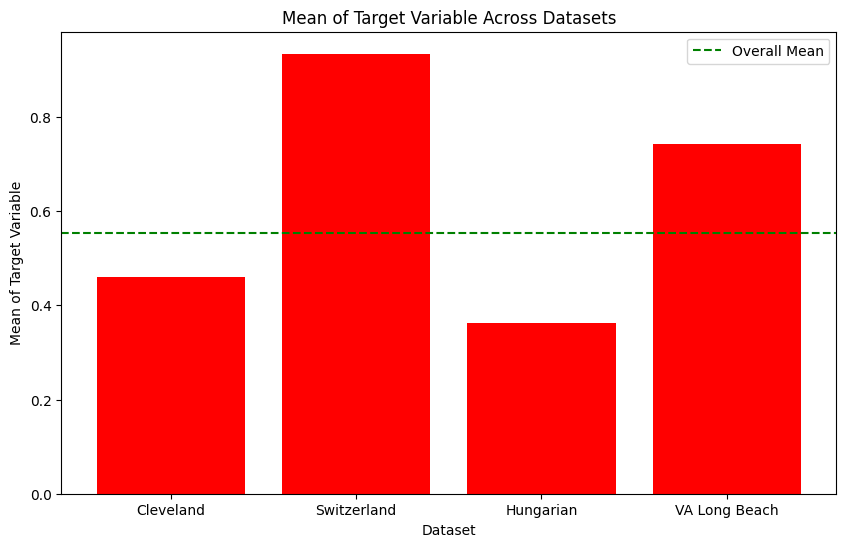

In [120]:
# Calculate overall mean of the target variable
overall_mean = pd.concat([clev_data['target'], switz_data['target'], hung_data['target'], va_data['target']]).mean()

# Calculate means for each dataset
dataset_means = [clev_data['target'].mean(), switz_data['target'].mean(), hung_data['target'].mean(), va_data['target'].mean()]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Cleveland', 'Switzerland', 'Hungarian', 'VA Long Beach'], dataset_means, color='red')
plt.axhline(y=overall_mean, color='green', linestyle='--', label='Overall Mean')
plt.xlabel('Dataset')
plt.ylabel('Mean of Target Variable')
plt.title('Mean of Target Variable Across Datasets')
plt.legend()
plt.show()

Note: Certain features are entirely null for certain datasets: `chol` is completley null in the Switzerland dataset, `ca` is completley null in the V.A. and Hungarian datasets.

In [121]:
clev_stats = clev_data.describe().round(2)
median_values = clev_data.median()
clev_stats.loc['median'] = median_values
print(f'Cleveland Overall: Mean, Median, Standard Deviation of Variables')
clev_stats

Cleveland Overall: Mean, Median, Standard Deviation of Variables


age     sex      cp  trestbps    chol     fbs  restecg  thalach  \
count   302.00  302.00  302.00    302.00  302.00  302.00   302.00   302.00   
mean     54.41    0.68    3.17    131.65  246.74    0.15     0.99   149.61   
std       9.04    0.47    0.95     17.61   51.86    0.35     0.99    22.91   
min      29.00    0.00    1.00     94.00  126.00    0.00     0.00    71.00   
25%      48.00    0.00    3.00    120.00  211.00    0.00     0.00   133.25   
50%      55.50    1.00    3.00    130.00  241.50    0.00     0.50   153.00   
75%      61.00    1.00    4.00    140.00  275.00    0.00     2.00   166.00   
max      77.00    1.00    4.00    200.00  564.00    1.00     2.00   202.00   
median   55.50    1.00    3.00    130.00  241.50    0.00     0.50   153.00   

         exang  oldpeak   slope      ca    thal  target  
count   302.00   302.00  302.00  298.00  300.00  302.00  
mean      0.33     1.04    1.60    0.67    4.73    0.46  
std       0.47     1.16    0.61    0.94    1.94    0.50  
min       0.00     0.00    1.00    0.00    3.00    0.00  
25%       0.00     0.00    1.00    0.00    3.00    0.00  
50%       0.00     0.80    2.00    0.00    3.00    0.00  
75%       1.00     1.60    2.00    1.00    7.00    1.00  
max       1.00     6.20    3.00    3.00    7.00    1.00  
median    0.00     0.80    2.00    0.00    3.00    0.00

In [122]:
clev_stats_f = clev_data_f.describe().round(2)
median_values = clev_data_f.median()
clev_stats_f.loc['median'] = median_values
print(f'Cleveland Female: Mean, Median, Standard Deviation of Variables')
clev_stats_f

Cleveland Female: Mean, Median, Standard Deviation of Variables


age   sex     cp  trestbps    chol    fbs  restecg  thalach  exang  \
count   97.00  97.0  97.00     97.00   97.00  97.00    97.00    97.00  97.00   
mean    55.72   0.0   3.14    133.34  261.75   0.12     0.96   151.23   0.23   
std      9.37   0.0   0.87     19.38   64.90   0.33     0.99    19.97   0.42   
min     34.00   0.0   1.00     94.00  141.00   0.00     0.00    96.00   0.00   
25%     50.00   0.0   3.00    120.00  215.00   0.00     0.00   142.00   0.00   
50%     57.00   0.0   3.00    132.00  254.00   0.00     0.00   157.00   0.00   
75%     63.00   0.0   4.00    140.00  302.00   0.00     2.00   165.00   0.00   
max     76.00   0.0   4.00    200.00  564.00   1.00     2.00   192.00   1.00   
median  57.00   0.0   3.00    132.00  254.00   0.00     0.00   157.00   0.00   

        oldpeak  slope     ca   thal  target  
count     97.00  97.00  97.00  96.00   97.00  
mean       0.87   1.57   0.55   3.66    0.26  
std        1.12   0.59   0.88   1.48    0.44  
min        0.00   1.00   0.00   3.00    0.00  
25%        0.00   1.00   0.00   3.00    0.00  
50%        0.60   2.00   0.00   3.00    0.00  
75%        1.40   2.00   1.00   3.00    1.00  
max        6.20   3.00   3.00   7.00    1.00  
median     0.60   2.00   0.00   3.00    0.00

In [123]:
clev_stats_m = clev_data_m.describe().round(2)
median_values = clev_data_m.median()
clev_stats_m.loc['median'] = median_values
print(f'Cleveland Male: Mean, Median, Standard Deviation of Variables')
clev_stats_m

Cleveland Male: Mean, Median, Standard Deviation of Variables


age    sex      cp  trestbps    chol     fbs  restecg  thalach  \
count   205.00  205.0  205.00    205.00  205.00  205.00    205.0   205.00   
mean     53.79    1.0    3.18    130.84  239.63    0.16      1.0   148.84   
std       8.84    0.0    0.99     16.70   42.75    0.36      1.0    24.19   
min      29.00    1.0    1.00     94.00  126.00    0.00      0.0    71.00   
25%      47.00    1.0    3.00    120.00  208.00    0.00      0.0   132.00   
50%      54.00    1.0    4.00    130.00  235.00    0.00      1.0   151.00   
75%      59.00    1.0    4.00    140.00  269.00    0.00      2.0   168.00   
max      77.00    1.0    4.00    192.00  353.00    1.00      2.0   202.00   
median   54.00    1.0    4.00    130.00  235.00    0.00      1.0   151.00   

         exang  oldpeak   slope      ca    thal  target  
count   205.00   205.00  205.00  201.00  204.00  205.00  
mean      0.38     1.12    1.61    0.74    5.24    0.56  
std       0.49     1.17    0.62    0.96    1.93    0.50  
min       0.00     0.00    1.00    0.00    3.00    0.00  
25%       0.00     0.00    1.00    0.00    3.00    0.00  
50%       0.00     0.80    2.00    0.00    6.50    1.00  
75%       1.00     1.80    2.00    1.00    7.00    1.00  
max       1.00     5.60    3.00    3.00    7.00    1.00  
median    0.00     0.80    2.00    0.00    6.50    1.00

In [124]:
switz_stats = switz_data.describe().round(2)
median_values = switz_data.median()
switz_stats.loc['median'] = median_values
print(f'Switzerland Overall: Mean, Median, Standard Deviation of Variables')
switz_stats

Switzerland Overall: Mean, Median, Standard Deviation of Variables


age     sex      cp  trestbps   chol    fbs  restecg  thalach  \
count   122.00  122.00  122.00    120.00  122.0  48.00   121.00   121.00   
mean     55.51    0.92    3.72    130.50    0.0   0.10     0.36   121.51   
std       8.82    0.28    0.65     22.42    0.0   0.31     0.59    26.08   
min      34.00    0.00    1.00     80.00    0.0   0.00     0.00    60.00   
25%      51.00    1.00    4.00    115.00    0.0   0.00     0.00   104.00   
50%      56.00    1.00    4.00    127.50    0.0   0.00     0.00   121.00   
75%      61.75    1.00    4.00    145.00    0.0   0.00     1.00   140.00   
max      74.00    1.00    4.00    200.00    0.0   1.00     2.00   182.00   
median   56.00    1.00    4.00    127.50    0.0   0.00     0.00   121.00   

         exang  oldpeak   slope    ca   thal  target  
count   121.00   116.00  105.00  5.00  71.00  122.00  
mean      0.45     0.65    1.81  1.60   5.79    0.93  
std       0.50     1.06    0.62  0.55   1.73    0.25  
min       0.00    -2.60    1.00  1.00   3.00    0.00  
25%       0.00     0.00    1.00  1.00   3.00    1.00  
50%       0.00     0.30    2.00  2.00   7.00    1.00  
75%       1.00     1.50    2.00  2.00   7.00    1.00  
max       1.00     3.70    3.00  2.00   7.00    1.00  
median    0.00     0.30    2.00  2.00   7.00    1.00

In [125]:
switz_stats_f = switz_data_f.describe().round(2)
median_values = switz_data_f.median()
switz_stats_f.loc['median'] = median_values
print(f'Switzerland Female: Mean, Median, Standard Deviation of Variables')
switz_stats_f

Switzerland Female: Mean, Median, Standard Deviation of Variables


age   sex     cp  trestbps  chol  fbs  restecg  thalach  exang  \
count   10.00  10.0  10.00     10.00  10.0  3.0    10.00    10.00  10.00   
mean    56.80   0.0   3.60    136.50   0.0  0.0     0.20   132.10   0.30   
std     11.98   0.0   0.97     32.41   0.0  0.0     0.42    22.51   0.48   
min     38.00   0.0   1.00     95.00   0.0  0.0     0.00    90.00   0.00   
25%     50.25   0.0   4.00    112.50   0.0  0.0     0.00   121.50   0.00   
50%     62.00   0.0   4.00    130.00   0.0  0.0     0.00   133.50   0.00   
75%     64.00   0.0   4.00    158.75   0.0  0.0     0.00   144.50   0.75   
max     73.00   0.0   4.00    200.00   0.0  0.0     1.00   166.00   1.00   
median  62.00   0.0   4.00    130.00   0.0  0.0     0.00   133.50   0.00   

        oldpeak  slope   ca  thal  target  
count     10.00   7.00  0.0  6.00    10.0  
mean       0.81   1.86  NaN  3.67     1.0  
std        0.98   0.90  NaN  1.63     0.0  
min        0.00   1.00  NaN  3.00     1.0  
25%        0.00   1.00  NaN  3.00     1.0  
50%        0.50   2.00  NaN  3.00     1.0  
75%        1.40   2.50  NaN  3.00     1.0  
max        2.80   3.00  NaN  7.00     1.0  
median     0.50   2.00  NaN  3.00     1.0

In [126]:
switz_stats_m = switz_data_m.describe().round(2)
median_values = switz_data_m.median()
switz_stats_m.loc['median'] = median_values
print(f'Switzerland Male: Mean, Median, Standard Deviation of Variables')
switz_stats_m

Switzerland Male: Mean, Median, Standard Deviation of Variables


age    sex      cp  trestbps   chol    fbs  restecg  thalach  \
count   112.00  112.0  112.00    110.00  112.0  45.00   111.00   111.00   
mean     55.39    1.0    3.73    129.95    0.0   0.11     0.38   120.56   
std       8.54    0.0    0.61     21.41    0.0   0.32     0.60    26.26   
min      34.00    1.0    1.00     80.00    0.0   0.00     0.00    60.00   
25%      51.00    1.0    4.00    115.00    0.0   0.00     0.00   101.50   
50%      56.00    1.0    4.00    127.50    0.0   0.00     0.00   120.00   
75%      61.00    1.0    4.00    145.00    0.0   0.00     1.00   138.50   
max      74.00    1.0    4.00    200.00    0.0   1.00     2.00   182.00   
median   56.00    1.0    4.00    127.50    0.0   0.00     0.00   120.00   

         exang  oldpeak  slope    ca   thal  target  
count   111.00   106.00  98.00  5.00  65.00  112.00  
mean      0.46     0.64   1.81  1.60   5.98    0.93  
std       0.50     1.07   0.60  0.55   1.62    0.26  
min       0.00    -2.60   1.00  1.00   3.00    0.00  
25%       0.00     0.00   1.00  1.00   6.00    1.00  
50%       0.00     0.30   2.00  2.00   7.00    1.00  
75%       1.00     1.50   2.00  2.00   7.00    1.00  
max       1.00     3.70   3.00  2.00   7.00    1.00  
median    0.00     0.30   2.00  2.00   7.00    1.00

In [127]:
hung_stats = hung_data.describe().round(2)
median_values = hung_data.median()
hung_stats.loc['median'] = median_values
print(f'Hungarian Overall: Mean, Median, Standard Deviation of Variables')
hung_stats

Hungarian Overall: Mean, Median, Standard Deviation of Variables


age     sex      cp  trestbps    chol     fbs  restecg  thalach  \
count   293.00  293.00  293.00    292.00  270.00  285.00   292.00   292.00   
mean     47.89    0.72    2.99    132.59  251.29    0.07     0.21   138.97   
std       7.74    0.45    0.97     17.66   67.39    0.26     0.45    23.48   
min      29.00    0.00    1.00     92.00   85.00    0.00     0.00    82.00   
25%      42.00    0.00    2.00    120.00  209.25    0.00     0.00   122.00   
50%      49.00    1.00    3.00    130.00  244.00    0.00     0.00   140.00   
75%      54.00    1.00    4.00    140.00  282.75    0.00     0.00   155.00   
max      66.00    1.00    4.00    200.00  603.00    1.00     2.00   190.00   
median   49.00    1.00    3.00    130.00  244.00    0.00     0.00   140.00   

         exang  oldpeak   slope   ca   thal  target  
count   292.00   293.00  104.00  3.0  28.00  293.00  
mean      0.30     0.59    1.89  0.0   5.64    0.36  
std       0.46     0.91    0.34  0.0   1.62    0.48  
min       0.00     0.00    1.00  0.0   3.00    0.00  
25%       0.00     0.00    2.00  0.0   5.25    0.00  
50%       0.00     0.00    2.00  0.0   6.00    0.00  
75%       1.00     1.00    2.00  0.0   7.00    1.00  
max       1.00     5.00    3.00  0.0   7.00    1.00  
median    0.00     0.00    2.00  0.0   6.00    0.00

In [128]:
hung_stats_f = hung_data_f.describe().round(2)
median_values = hung_data_f.median()
hung_stats_f.loc['median'] = median_values
print(f'Hungarian Female: Mean, Median, Standard Deviation of Variables')
hung_stats_f

Hungarian Female: Mean, Median, Standard Deviation of Variables


age   sex     cp  trestbps    chol    fbs  restecg  thalach  exang  \
count   81.00  81.0  81.00     80.00   74.00  77.00    81.00    80.00  80.00   
mean    47.65   0.0   2.59    130.02  247.68   0.05     0.30   143.43   0.19   
std      7.30   0.0   0.91     18.13   62.20   0.22     0.49    22.83   0.39   
min     30.00   0.0   1.00    100.00  160.00   0.00     0.00    90.00   0.00   
25%     43.00   0.0   2.00    120.00  201.25   0.00     0.00   129.75   0.00   
50%     48.00   0.0   2.00    130.00  233.50   0.00     0.00   142.00   0.00   
75%     53.00   0.0   3.00    140.00  282.75   0.00     1.00   160.00   0.00   
max     62.00   0.0   4.00    180.00  468.00   1.00     2.00   190.00   1.00   
median  48.00   0.0   2.00    130.00  233.50   0.00     0.00   142.00   0.00   

        oldpeak  slope   ca  thal  target  
count     81.00  26.00  0.0  7.00   81.00  
mean       0.41   1.77  NaN  6.00    0.15  
std        0.67   0.43  NaN  1.41    0.36  
min        0.00   1.00  NaN  3.00    0.00  
25%        0.00   2.00  NaN  6.00    0.00  
50%        0.00   2.00  NaN  6.00    0.00  
75%        1.00   2.00  NaN  7.00    0.00  
max        2.00   2.00  NaN  7.00    1.00  
median     0.00   2.00  NaN  6.00    0.00

In [129]:
hung_stats_m = hung_data_m.describe().round(2)
median_values = hung_data_m.median()
hung_stats_m.loc['median'] = median_values
print(f'Hungarian Male: Mean, Median, Standard Deviation of Variables')
hung_stats_m

Hungarian Male: Mean, Median, Standard Deviation of Variables


age    sex      cp  trestbps    chol     fbs  restecg  thalach  \
count   212.00  212.0  212.00    212.00  196.00  208.00   211.00   212.00   
mean     47.99    1.0    3.14    133.56  252.65    0.08     0.18   137.29   
std       7.91    0.0    0.95     17.42   69.36    0.27     0.43    23.55   
min      29.00    1.0    1.00     92.00   85.00    0.00     0.00    82.00   
25%      41.75    1.0    2.00    120.00  212.75    0.00     0.00   120.00   
50%      49.00    1.0    3.00    130.00  246.00    0.00     0.00   139.00   
75%      54.00    1.0    4.00    140.00  282.25    0.00     0.00   152.00   
max      66.00    1.0    4.00    200.00  603.00    1.00     2.00   188.00   
median   49.00    1.0    3.00    130.00  246.00    0.00     0.00   139.00   

         exang  oldpeak  slope   ca   thal  target  
count   212.00   212.00  78.00  3.0  21.00  212.00  
mean      0.35     0.66   1.94  0.0   5.52    0.44  
std       0.48     0.98   0.29  0.0   1.69    0.50  
min       0.00     0.00   1.00  0.0   3.00    0.00  
25%       0.00     0.00   2.00  0.0   3.00    0.00  
50%       0.00     0.00   2.00  0.0   6.00    0.00  
75%       1.00     1.00   2.00  0.0   7.00    1.00  
max       1.00     5.00   3.00  0.0   7.00    1.00  
median    0.00     0.00   2.00  0.0   6.00    0.00

In [130]:
va_stats = va_data.describe().round(2)
median_values = va_data.median()
va_stats.loc['median'] = median_values
print(f'VA Overall: Mean, Median, Standard Deviation of Variables')
va_stats

VA Overall: Mean, Median, Standard Deviation of Variables


age     sex     cp  trestbps    chol     fbs  restecg  thalach  \
count   199.00  199.00  199.0    143.00  192.00  192.00   199.00   146.00   
mean     59.33    0.97    3.5    133.72  178.32    0.35     0.73   122.87   
std       7.83    0.17    0.8     21.61  114.18    0.48     0.68    22.05   
min      35.00    0.00    1.0      0.00    0.00    0.00     0.00    69.00   
25%      55.00    1.00    3.0    120.00    0.00    0.00     0.00   108.50   
50%      60.00    1.00    4.0    130.00  216.00    0.00     1.00   120.00   
75%      64.00    1.00    4.0    148.00  256.50    1.00     1.00   140.00   
max      77.00    1.00    4.0    190.00  458.00    1.00     2.00   180.00   
median   60.00    1.00    4.0    130.00  216.00    0.00     1.00   120.00   

         exang  oldpeak  slope   ca   thal  target  
count   146.00   143.00  97.00  2.0  34.00  199.00  
mean      0.64     1.31   2.13  0.0   6.29    0.74  
std       0.48     1.10   0.67  0.0   1.29    0.44  
min       0.00    -0.50   1.00  0.0   3.00    0.00  
25%       0.00     0.00   2.00  0.0   6.00    0.00  
50%       1.00     1.50   2.00  0.0   7.00    1.00  
75%       1.00     2.00   3.00  0.0   7.00    1.00  
max       1.00     4.00   3.00  0.0   7.00    1.00  
median    1.00     1.50   2.00  0.0   7.00    1.00

In [131]:
va_stats_f = va_data_f.describe().round(2)
median_values = va_data_f.median()
va_stats_f.loc['median'] = median_values
print(f'VA Female: Mean, Median, Standard Deviation of Variables')
va_stats_f

VA Female: Mean, Median, Standard Deviation of Variables


age  sex    cp  trestbps    chol   fbs  restecg  thalach  exang  \
count    6.00  6.0  6.00      5.00    6.00  6.00     6.00     5.00   5.00   
mean    57.83  0.0  3.33    132.20  239.83  0.50     0.50   123.00   0.60   
std      5.49  0.0  1.03     11.71  120.32  0.55     0.84    24.04   0.55   
min     51.00  0.0  2.00    114.00    0.00  0.00     0.00    96.00   0.00   
25%     54.00  0.0  2.50    127.00  262.00  0.00     0.00   105.00   0.00   
50%     57.50  0.0  4.00    138.00  275.00  0.50     0.00   120.00   1.00   
75%     62.50  0.0  4.00    140.00  292.50  1.00     0.75   140.00   1.00   
max     64.00  0.0  4.00    142.00  333.00  1.00     2.00   154.00   1.00   
median  57.50  0.0  4.00    138.00  275.00  0.50     0.00   120.00   1.00   

        oldpeak  slope   ca  thal  target  
count      5.00   3.00  0.0   2.0    6.00  
mean       0.70   1.67  NaN   7.0    0.50  
std        0.67   0.58  NaN   0.0    0.55  
min        0.00   1.00  NaN   7.0    0.00  
25%        0.00   1.50  NaN   7.0    0.00  
50%        1.00   2.00  NaN   7.0    0.50  
75%        1.00   2.00  NaN   7.0    1.00  
max        1.50   2.00  NaN   7.0    1.00  
median     1.00   2.00  NaN   7.0    0.50

In [132]:
va_stats_m = va_data_m.describe().round(2)
median_values = va_data_m.median()
va_stats_m.loc['median'] = median_values
print(f'VA Male: Mean, Median, Standard Deviation of Variables')
va_stats_m

VA Male: Mean, Median, Standard Deviation of Variables


age    sex      cp  trestbps    chol     fbs  restecg  thalach  \
count   193.00  193.0  193.00    138.00  186.00  186.00   193.00   141.00   
mean     59.38    1.0    3.51    133.78  176.34    0.35     0.74   122.87   
std       7.89    0.0    0.79     21.90  113.76    0.48     0.68    22.07   
min      35.00    1.0    1.00      0.00    0.00    0.00     0.00    69.00   
25%      55.00    1.0    3.00    120.00    0.00    0.00     0.00   110.00   
50%      60.00    1.0    4.00    130.00  214.00    0.00     1.00   120.00   
75%      64.00    1.0    4.00    150.00  253.50    1.00     1.00   140.00   
max      77.00    1.0    4.00    190.00  458.00    1.00     2.00   180.00   
median   60.00    1.0    4.00    130.00  214.00    0.00     1.00   120.00   

         exang  oldpeak  slope   ca   thal  target  
count   141.00   138.00  94.00  2.0  32.00  193.00  
mean      0.65     1.33   2.15  0.0   6.25    0.75  
std       0.48     1.11   0.67  0.0   1.32    0.43  
min       0.00    -0.50   1.00  0.0   3.00    0.00  
25%       0.00     0.00   2.00  0.0   6.00    1.00  
50%       1.00     1.50   2.00  0.0   7.00    1.00  
75%       1.00     2.00   3.00  0.0   7.00    1.00  
max       1.00     4.00   3.00  0.0   7.00    1.00  
median    1.00     1.50   2.00  0.0   7.00    1.00

### c. Plot figures and explain

i. Examples: histograms or density plots showing the distributions of relevant outcome variables, broken down by different sensitive attribute subgroups. Scatterplots showing the relationships between different variables to be used in your analysis. All plots should be easy to read (well-labeled, formatted well, etc.).    

The first set of figures below, represent the sex ratio of each dataset, where 1 is male and 0 is female.

As we can see, the female Sensitive Group is heavily undersampled in all datasets -- which could indicate the presence of bias in the sample collection process.

The following figures are correlation matrices across all datasets, detailing how connected the sensitive features are to one another, 1 being very connected, and -1 being very independent. As previously noticed, chol is completley null in the Switzerland dataset and ca is completley null in the V.A. and Hungarian datasets, leading to nan columns and rows with no correlation.

In [133]:
# Function to draw the heatmap in the upper triangle
def heatmap_upper(i, j):
    ax = grid.axes[i][j]
    corr = switz_data.corr().iloc[i, j]
    ax.set_facecolor(sns.diverging_palette(240, 10, as_cmap=True)(0.5 + corr / 2.0))
    ax.annotate(f"{corr:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center', fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(True)

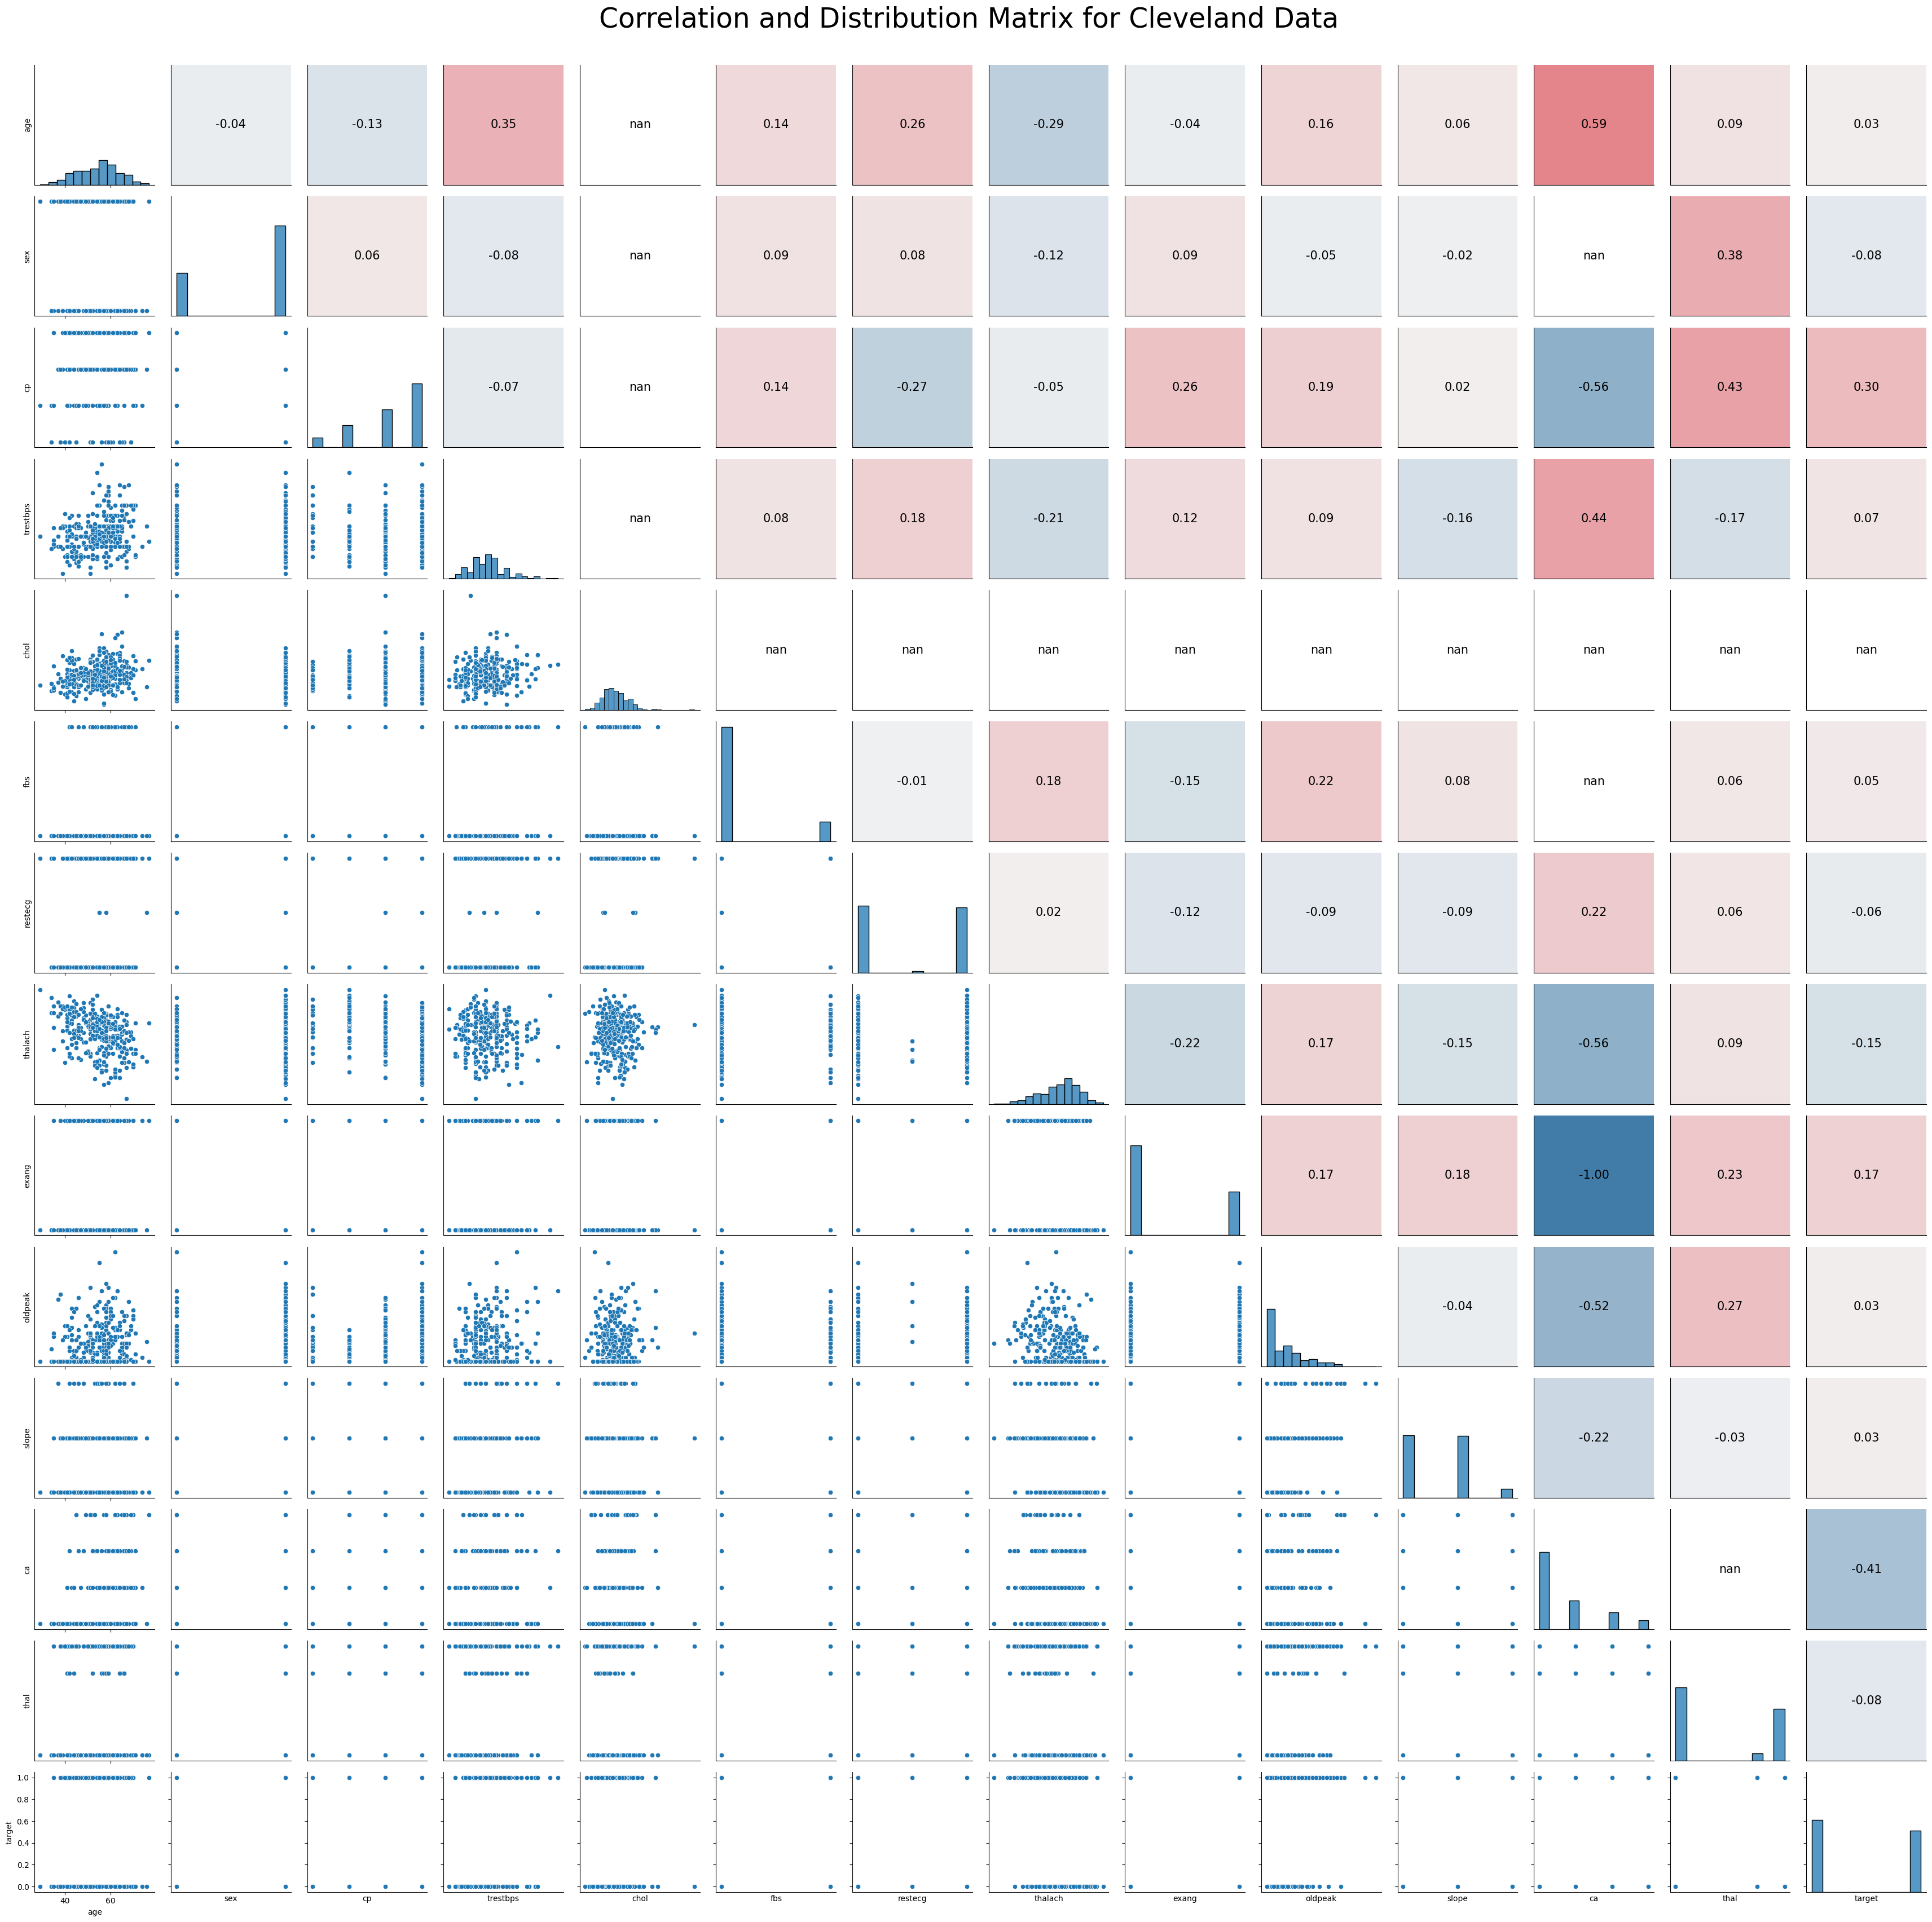

In [134]:
# Initialize the PairGrid
grid = sns.PairGrid(clev_data)

# Plot
grid.map_lower(sns.scatterplot)
grid.map_diag(sns.histplot)
for i, j in zip(*np.triu_indices_from(grid.axes, k=1)):
    heatmap_upper(i, j)
plt.subplots_adjust(top=0.95)
grid.fig.suptitle('Correlation and Distribution Matrix for Cleveland Data', fontsize=35)
plt.show()

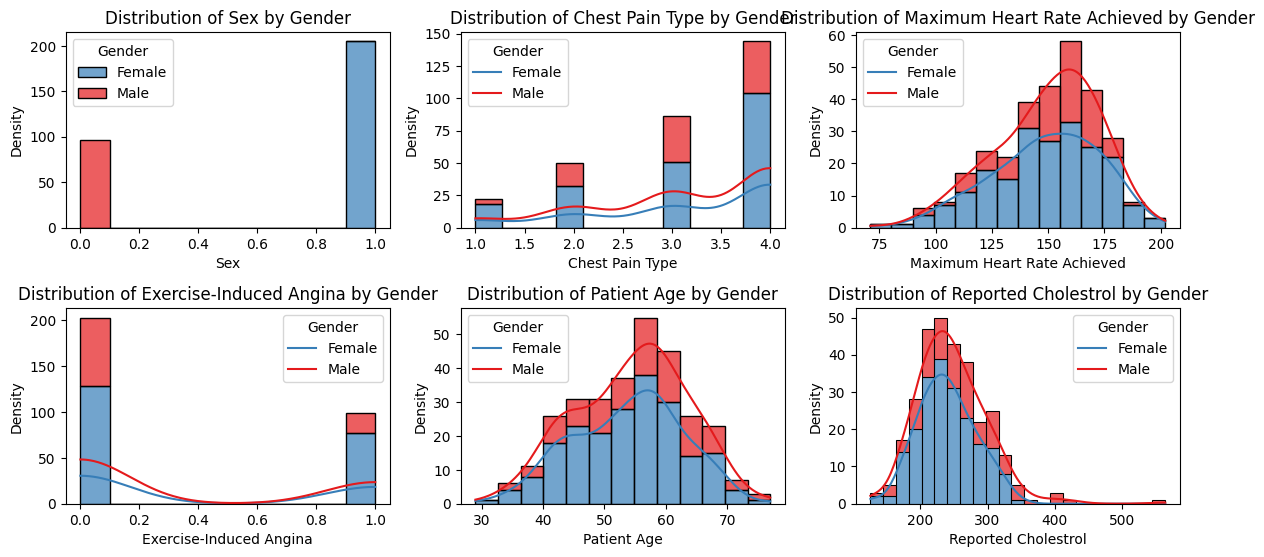

In [135]:
feature_meanings = {
    'sex': 'Sex',
    'cp': 'Chest Pain Type',
    'thalach': 'Maximum Heart Rate Achieved',
    'exang': 'Exercise-Induced Angina',
    'age' : 'Patient Age',
    'chol' : 'Reported Cholestrol'

}


gender_labels = {
    1: 'Male',
    0: 'Female'
}


subset_features = ['sex', 'cp', 'thalach', 'exang', 'age', 'chol']


plt.figure(figsize=(12, 8))
for i, feature in enumerate(subset_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=clev_data, x=feature, hue='sex', multiple='stack', kde=True, palette='Set1', alpha=0.7)
    plt.title(f'Distribution of {feature_meanings[feature]} by Gender')
    plt.xlabel(feature_meanings[feature])
    plt.ylabel('Density')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, [gender_labels[int(label)] for label in labels], title='Gender', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()


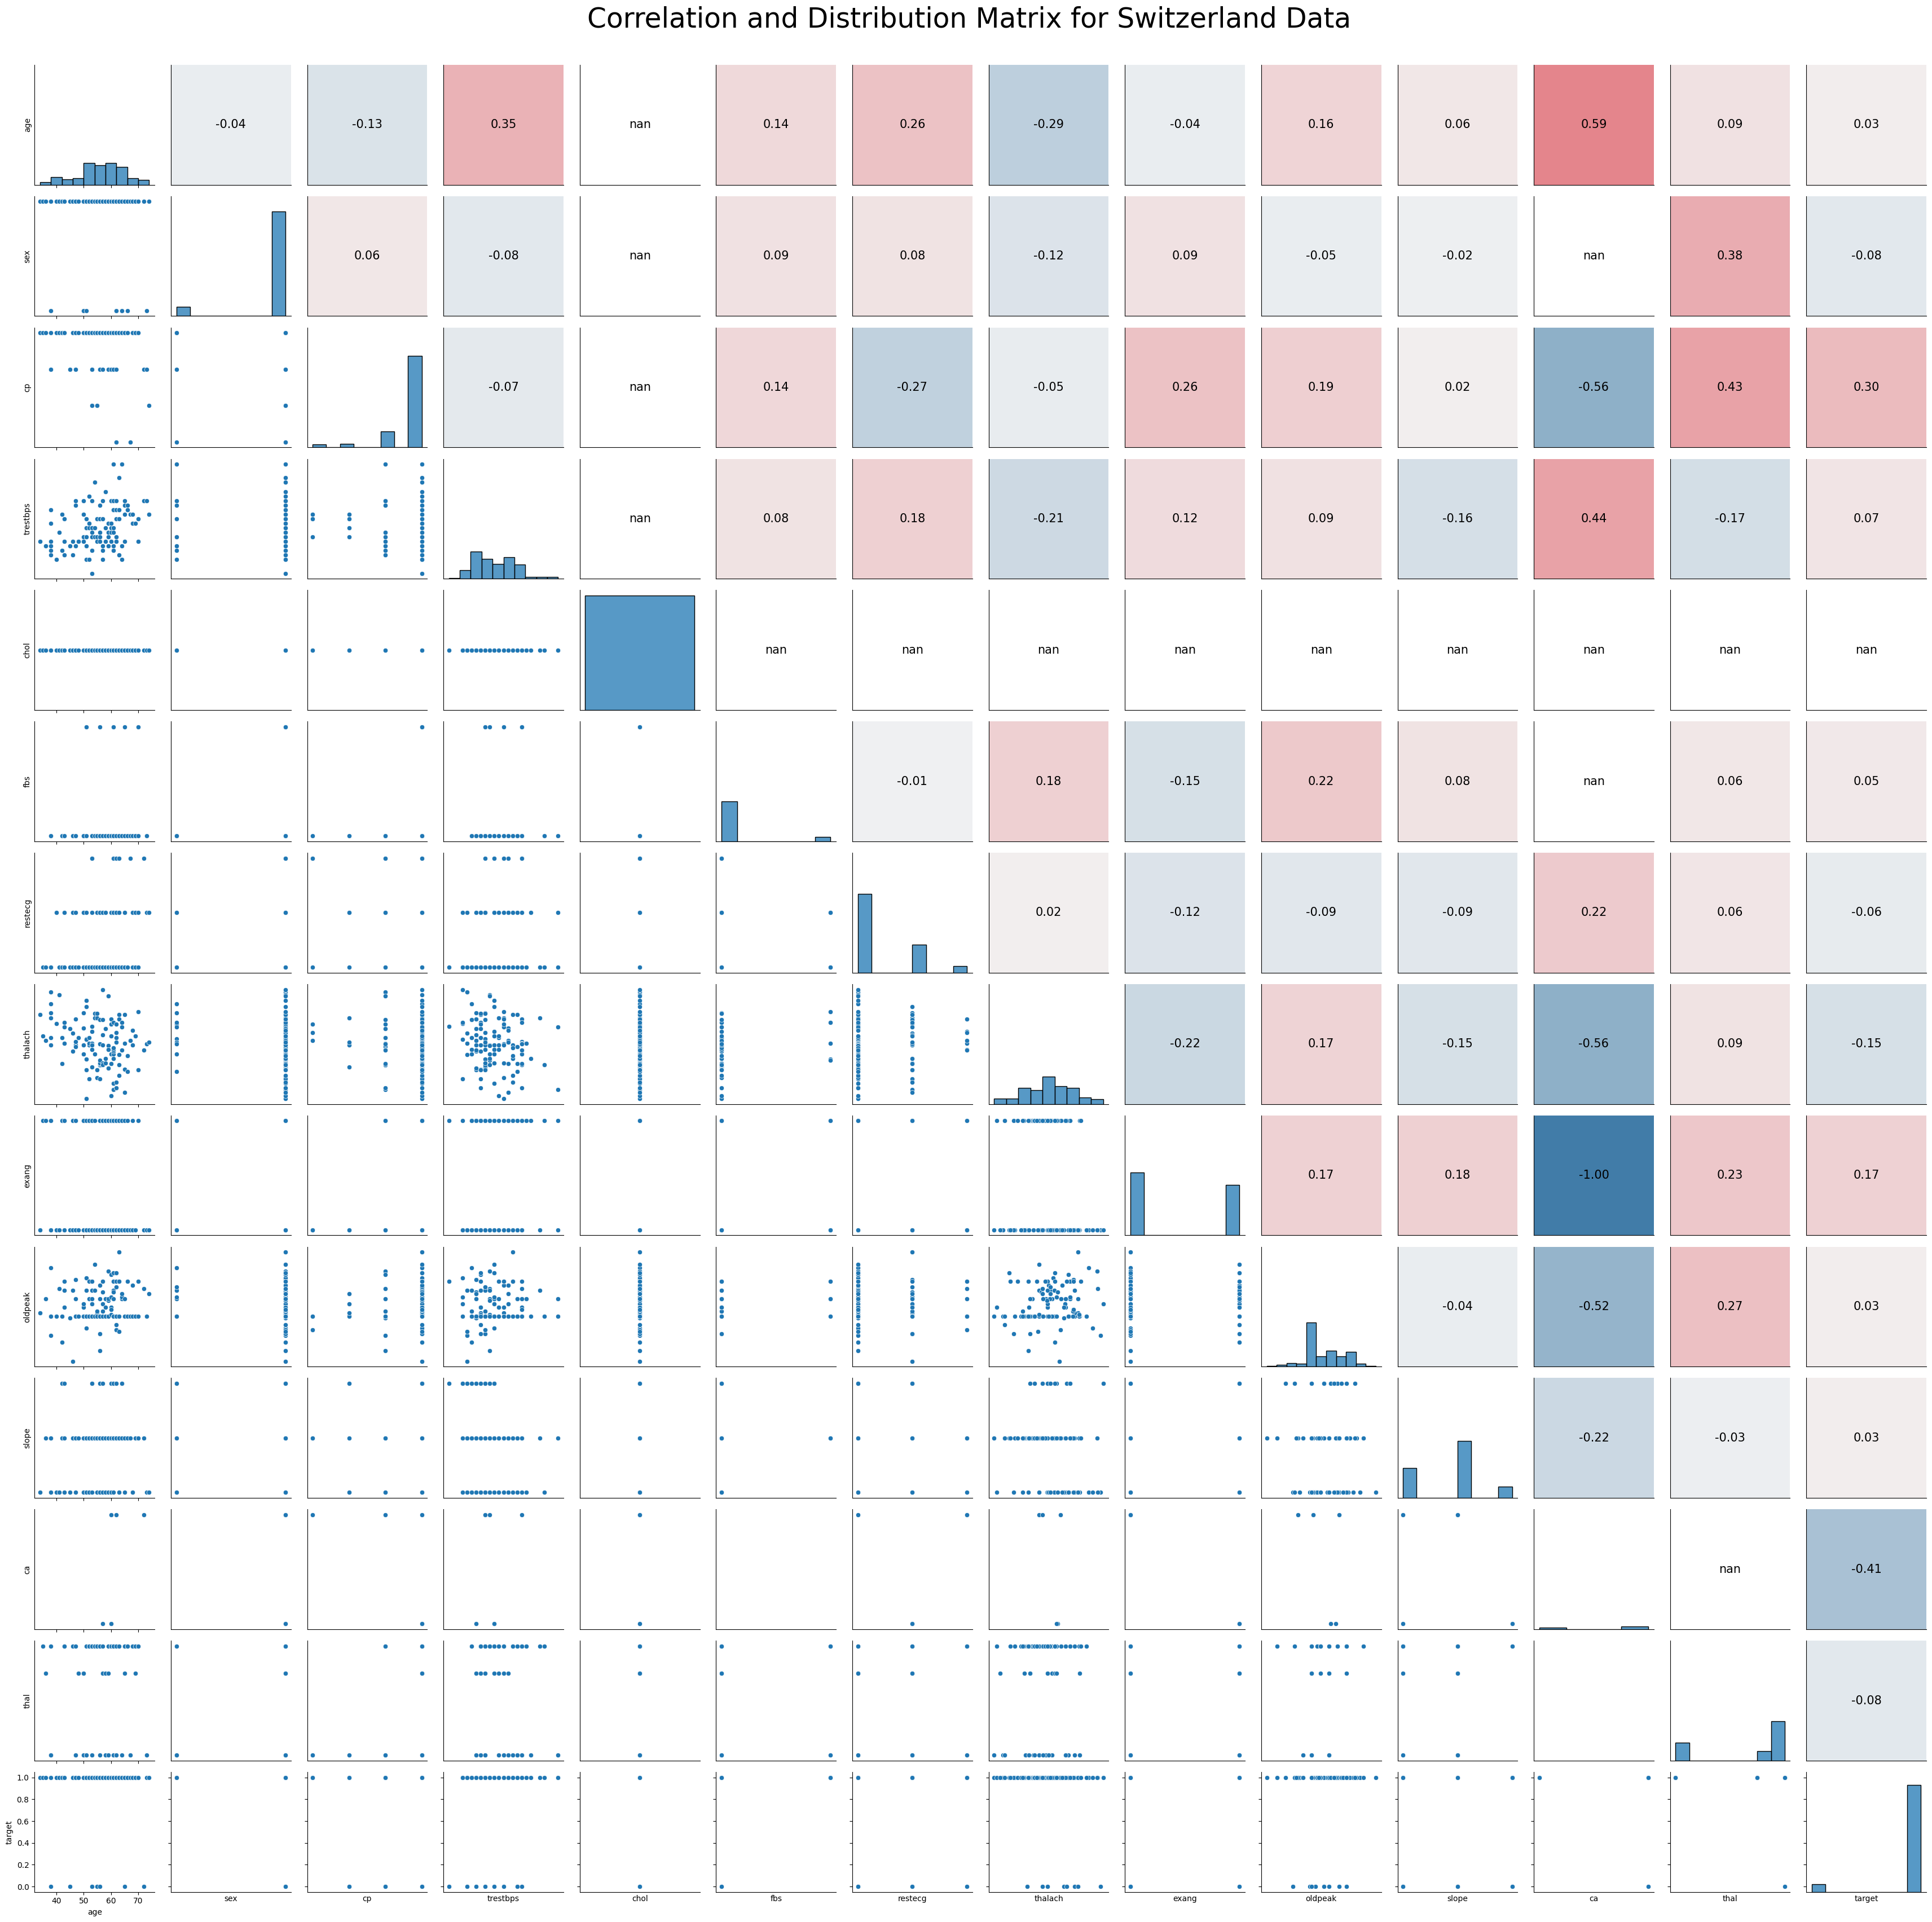

In [136]:
# Initialize the PairGrid
grid = sns.PairGrid(switz_data)

# Plot
grid.map_lower(sns.scatterplot)
grid.map_diag(sns.histplot)
for i, j in zip(*np.triu_indices_from(grid.axes, k=1)):
    heatmap_upper(i, j)

plt.subplots_adjust(top=0.95)
grid.fig.suptitle('Correlation and Distribution Matrix for Switzerland Data', fontsize=35)
plt.show()

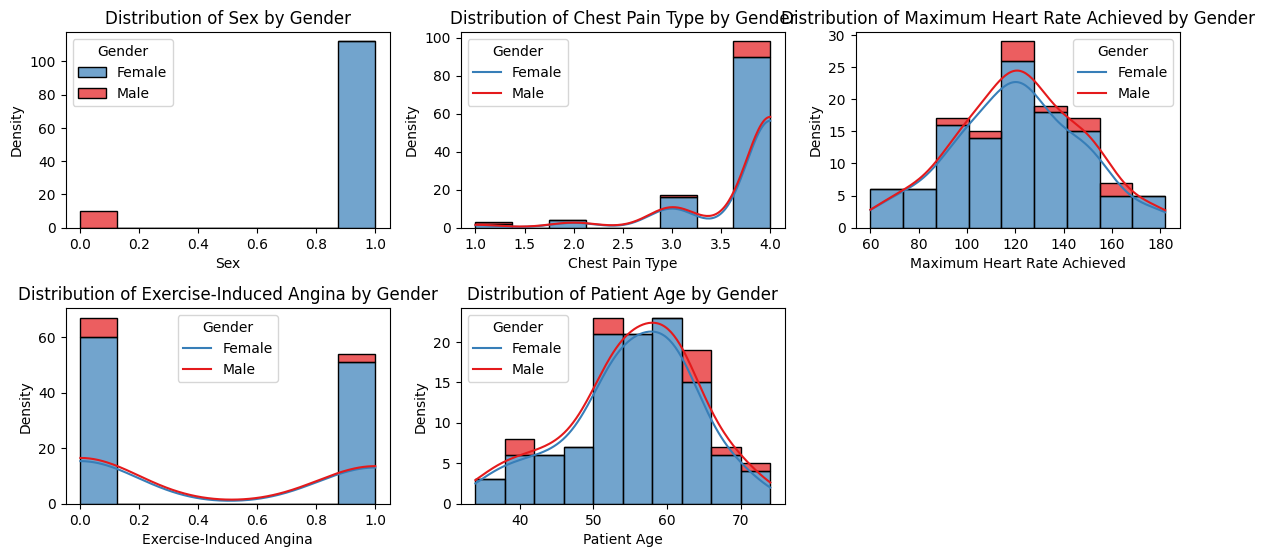

In [137]:
feature_meanings = {
    'sex': 'Sex',
    'cp': 'Chest Pain Type',
    'thalach': 'Maximum Heart Rate Achieved',
    'exang': 'Exercise-Induced Angina',
    'age' : 'Patient Age',
    #'chol' : 'Reported Cholestrol' cholestrol data too insignificant in Switzerland dataset to report causing linalg error

}


gender_labels = {
    1: 'Male',
    0: 'Female'
}


subset_features = ['sex', 'cp', 'thalach', 'exang', 'age']


plt.figure(figsize=(12, 8))
for i, feature in enumerate(subset_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=switz_data, x=feature, hue='sex', multiple='stack', kde=True, palette='Set1', alpha=0.7)
    plt.title(f'Distribution of {feature_meanings[feature]} by Gender')
    plt.xlabel(feature_meanings[feature])
    plt.ylabel('Density')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, [gender_labels[int(label)] for label in labels], title='Gender', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()


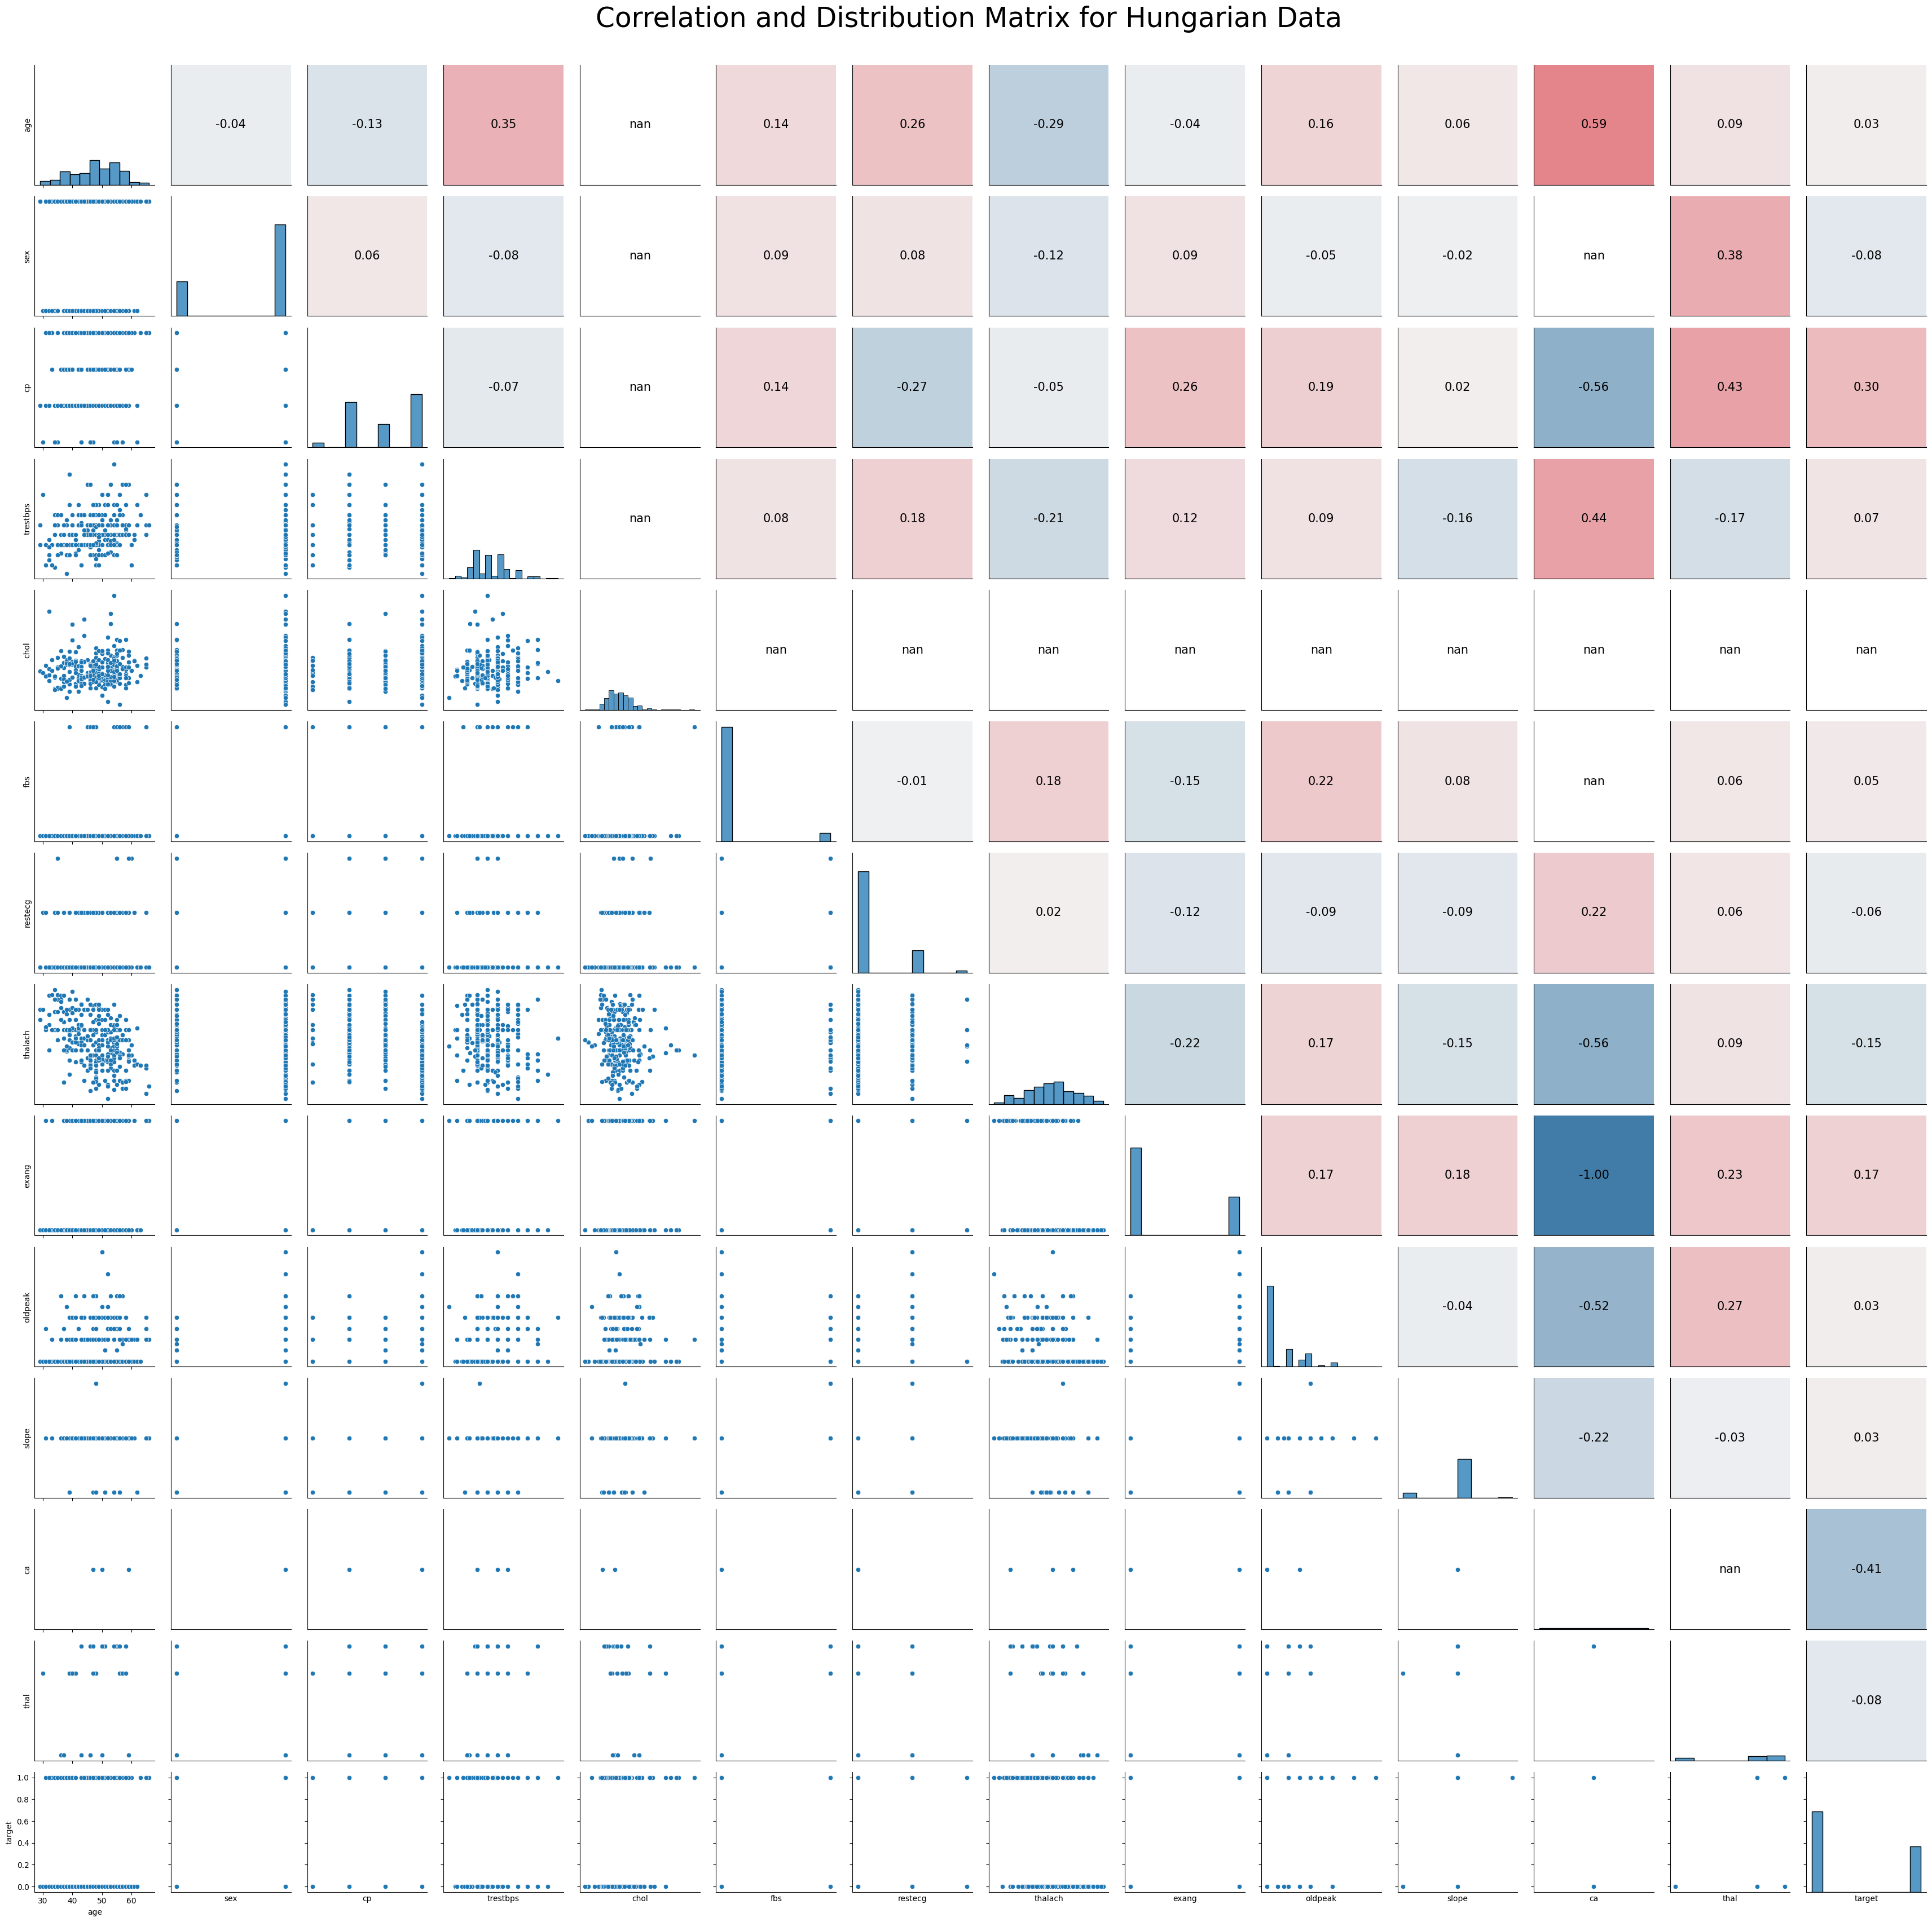

In [138]:
# Initialize the PairGrid
grid = sns.PairGrid(hung_data)

# Plot
grid.map_lower(sns.scatterplot)
grid.map_diag(sns.histplot)
for i, j in zip(*np.triu_indices_from(grid.axes, k=1)):
    heatmap_upper(i, j)
plt.subplots_adjust(top=0.95)
grid.fig.suptitle('Correlation and Distribution Matrix for Hungarian Data', fontsize=35)
plt.show()

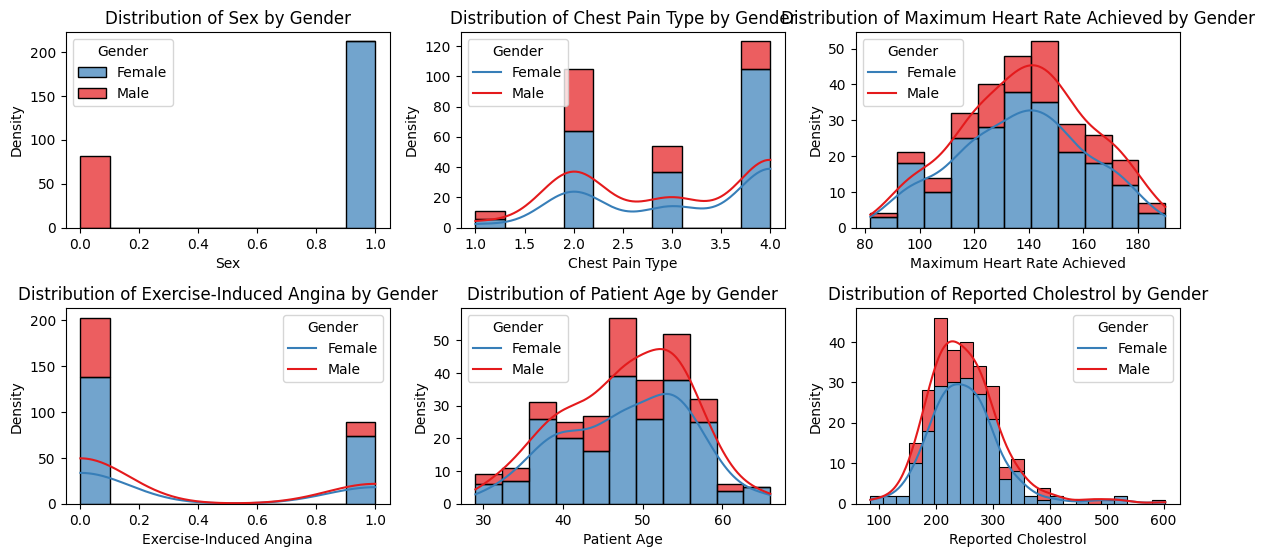

In [139]:
feature_meanings = {
    'sex': 'Sex',
    'cp': 'Chest Pain Type',
    'thalach': 'Maximum Heart Rate Achieved',
    'exang': 'Exercise-Induced Angina',
    'age' : 'Patient Age',
    'chol' : 'Reported Cholestrol'

}


gender_labels = {
    1: 'Male',
    0: 'Female'
}


subset_features = ['sex', 'cp', 'thalach', 'exang', 'age', 'chol']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(subset_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=hung_data, x=feature, hue='sex', multiple='stack', kde=True, palette='Set1', alpha=0.7)
    plt.title(f'Distribution of {feature_meanings[feature]} by Gender')
    plt.xlabel(feature_meanings[feature])
    plt.ylabel('Density')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, [gender_labels[int(label)] for label in labels], title='Gender', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()


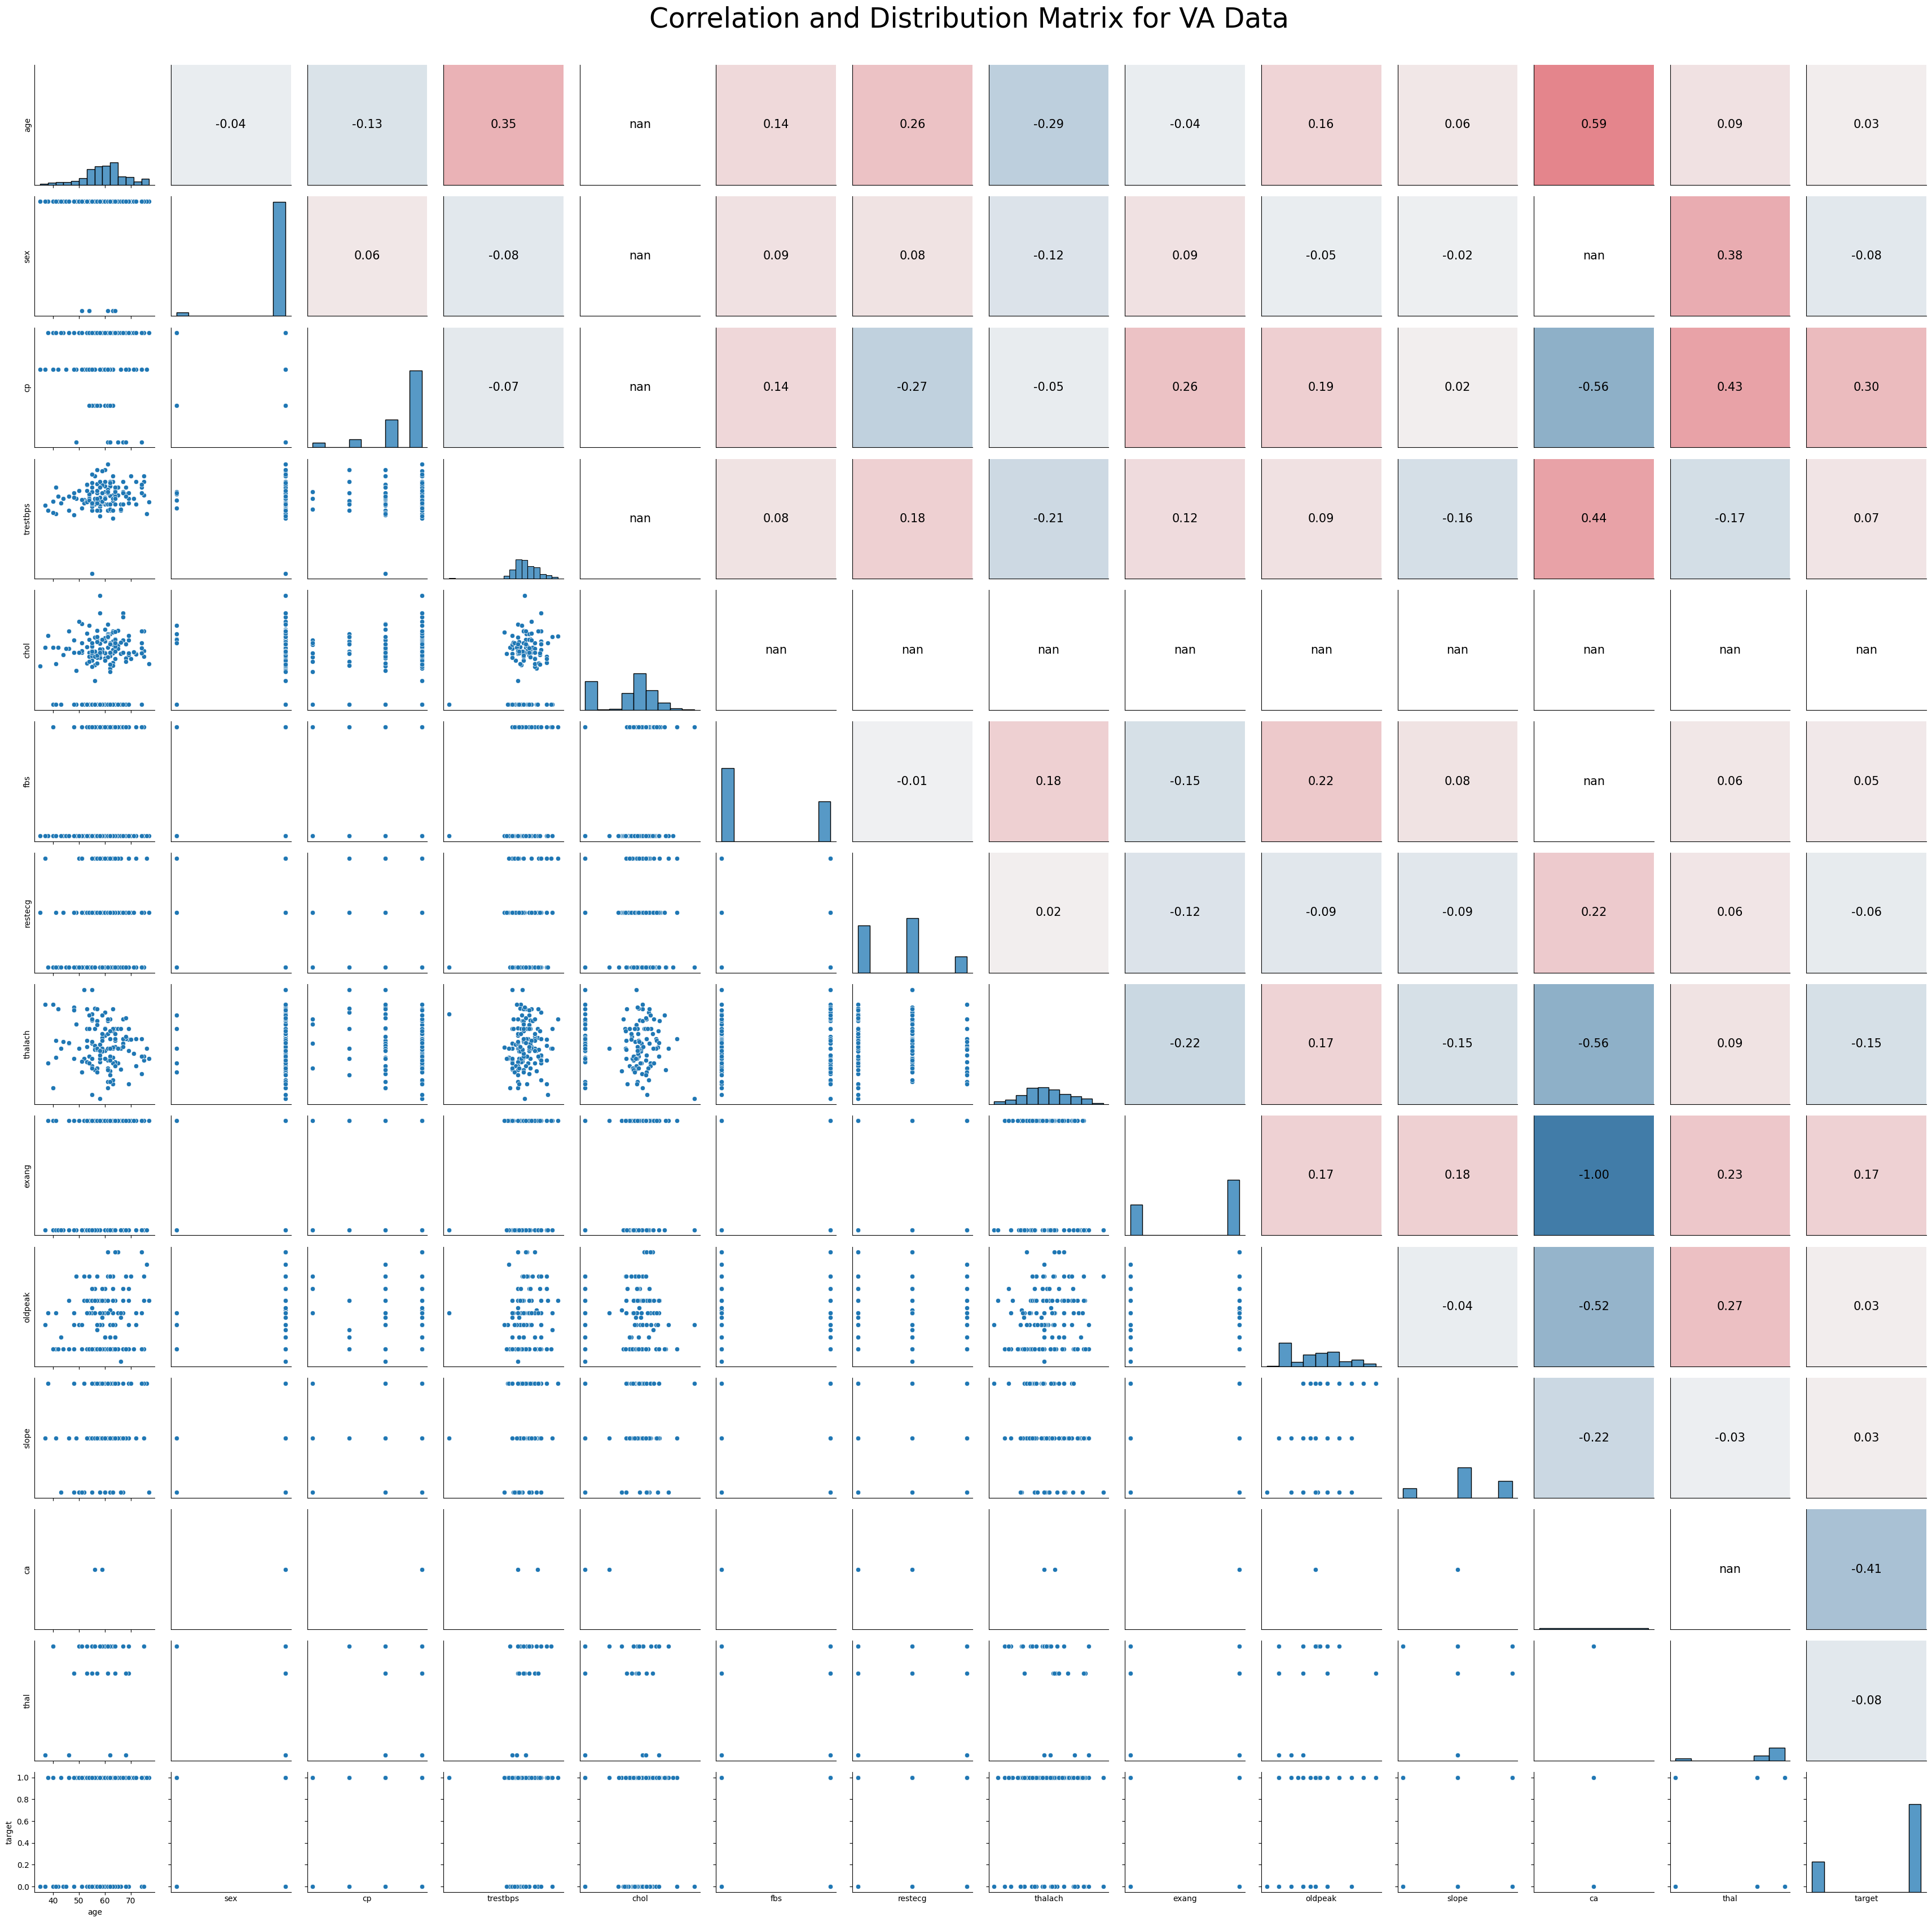

In [140]:
# Initialize the PairGrid
grid = sns.PairGrid(va_data)

# Plot
grid.map_lower(sns.scatterplot)
grid.map_diag(sns.histplot)
for i, j in zip(*np.triu_indices_from(grid.axes, k=1)):
    heatmap_upper(i, j)
plt.subplots_adjust(top=0.95)
grid.fig.suptitle('Correlation and Distribution Matrix for VA Data', fontsize=35)
plt.show()

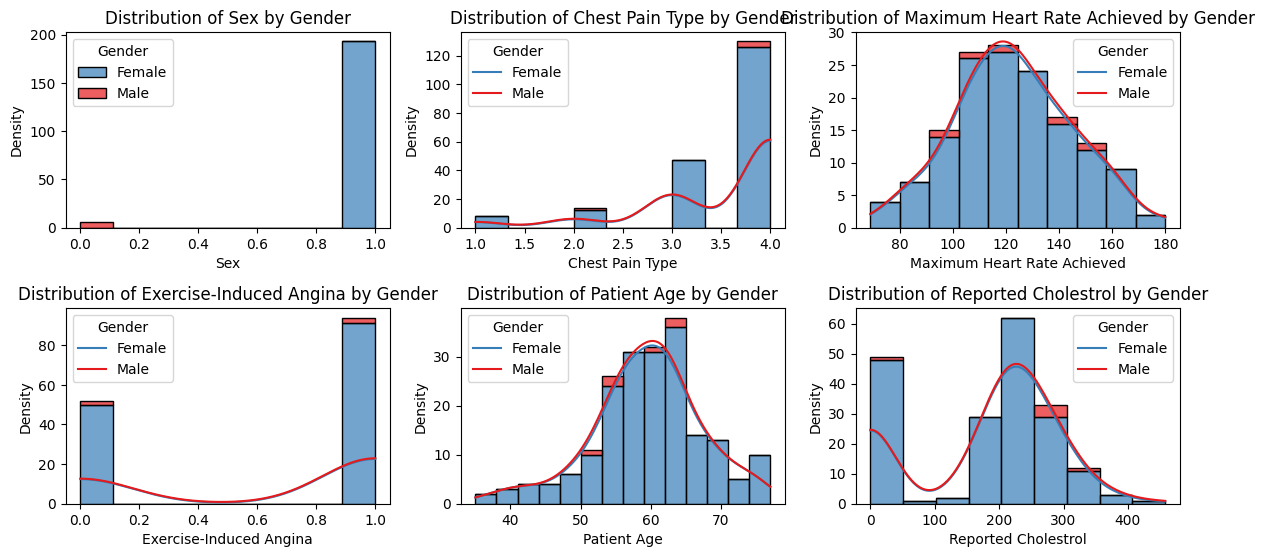

In [141]:
feature_meanings = {
    'sex': 'Sex',
    'cp': 'Chest Pain Type',
    'thalach': 'Maximum Heart Rate Achieved',
    'exang': 'Exercise-Induced Angina',
    'age' : 'Patient Age',
    'chol' : 'Reported Cholestrol'

}


gender_labels = {
    1: 'Male',
    0: 'Female'
}


subset_features = ['sex', 'cp', 'thalach', 'exang', 'age', 'chol']


plt.figure(figsize=(12, 8))
for i, feature in enumerate(subset_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=va_data, x=feature, hue='sex', multiple='stack', kde=True, palette='Set1', alpha=0.7)
    plt.title(f'Distribution of {feature_meanings[feature]} by Gender')
    plt.xlabel(feature_meanings[feature])
    plt.ylabel('Density')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, [gender_labels[int(label)] for label in labels], title='Gender', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()


Here we display the sex ratio of each dataset to show the overwhelming majority of male data to female data. Cleveland is the closest to having a reasonable ratio and it's still very skewed towards men, showing the innate bias of the entire model in Detrano et al. (1989)[1].

In [142]:
# Create 2x2 subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=("Sex Ratio in Cleveland Data",
                                                    "Sex Ratio in Switzerland Data",
                                                    "Sex Ratio in Hungarian Data",
                                                    "Sex Ratio in VA Data"))

# Plot Cleveland
fig.add_trace(go.Histogram(x=clev_data['sex']), row=1, col=1)
fig.add_annotation(x=0.5, y=max(clev_data['sex'].value_counts()),
                   text=f"Female (0s) as Proportion of Total: {sum(clev_data['sex'] == 0) / len(clev_data):.4f}",
                   showarrow=False,
                   yshift=20, row=1, col=1)

# Plot Switzerland
fig.add_trace(go.Histogram(x=switz_data['sex']), row=1, col=2)
fig.add_annotation(x=0.5, y=max(switz_data['sex'].value_counts()),
                   text=f"Female (0s) as Proportion of Total: {sum(switz_data['sex'] == 0) / len(switz_data):.4f}",
                   showarrow=False,
                   yshift=20, row=1, col=2)

# Plot Hungarian
fig.add_trace(go.Histogram(x=hung_data['sex']), row=2, col=1)
fig.add_annotation(x=0.5, y=max(hung_data['sex'].value_counts()),
                   text=f"Female (0s) as Proportion of Total: {sum(hung_data['sex'] == 0) / len(hung_data):.4f}",
                   showarrow=False,
                   yshift=20, row=2, col=1)

# Plot VA
fig.add_trace(go.Histogram(x=va_data['sex']), row=2, col=2)
fig.add_annotation(x=0.5, y=max(va_data['sex'].value_counts()),
                   text=f"Female (0s) as Proportion of Total: {sum(va_data['sex'] == 0) / len(va_data):.4f}",
                   showarrow=False,
                   yshift=20, row=2, col=2)

# Title and axes
fig.update_layout(title_text="Sex Ratios across Different Datasets (Sex of 0 is female; 1 is male)",
                  showlegend=False,
                  width=800,
                  height=800)
fig.update_xaxes(tickvals=[0, 1])
fig.show()

Digging deeper, we then plotted the target variable mean (heart disease prevalence) for each Sensitive Group, across all 4 datasets.

A target value of 0 indicates no heart disease diagnosis, and 1 indicates presence of heart disease.

We know from more current research (Framingham Study 2002 [3]) that heart disease prevalence is relatively similar between sexes.

These plots show that in the dataset used for the Detrano et. al study that women seem to have less cases of heart disease, but they mainly show how few female patients were included in these datasets, with only the Cleveland dataset having anywhere near an equal representation of sexes. The latter insight harms the credibility of the first.

In [143]:
# Function to calculate and plot ratios
def plot_stacked_ratio(data_f, data_m, data_t, row, col, show):
    # Calculate ratios
    ratio_f = data_f['target'].value_counts(normalize=True).sort_index()
    ratio_m = data_m['target'].value_counts(normalize=True).sort_index()
    ratio_t = data_t['target'].value_counts(normalize=True).sort_index()
   # Ensure both 0 and 1 are present
    for val in [0, 1]:
        if val not in ratio_f:
            ratio_f[val] = 0
        if val not in ratio_m:
            ratio_m[val] = 0
    # Text labels
    text_f = [f"{ratio_f[0]:.1%}", f"TP: {ratio_f[1]:.1%}"]
    text_m = [f"{ratio_m[0]:.1%}", f"TP: {ratio_m[1]:.1%}"]
    text_t = [f"{ratio_t[0]:.1%}", f"TP: {ratio_t[1]:.1%}"]

    # Plot - stack by adding two separate traces for each category, with unified colors for 0s and 1s
    fig.add_trace(go.Bar(x=[f'Female'], y=[ratio_f[0]], name='0', marker_color='lightgrey', showlegend=show), row=row, col=col)
    fig.add_trace(go.Bar(x=['Female'], y=[ratio_f[1]], name='1', marker_color='darkgrey', showlegend=show, text=text_f[1], textposition='inside', textfont=dict(size=10)), row=row, col=col)
    fig.add_trace(go.Bar(x=[f'Male'], y=[ratio_m[0]], name='0', marker_color='lightgrey', showlegend=False), row=row, col=col)
    fig.add_trace(go.Bar(x=[f'Male'], y=[ratio_m[1]], name='1', marker_color='darkgrey', showlegend=False, text=text_m[1], textposition='inside', textfont=dict(size=10)), row=row, col=col)
    fig.add_trace(go.Bar(x=[f'Total'], y=[ratio_t[0]], name='0', marker_color='lightgrey', showlegend=False), row=row, col=col)
    fig.add_trace(go.Bar(x=[f'Total'], y=[ratio_t[1]], name='1', marker_color='darkgrey', showlegend=False, text=text_t[1], textposition='inside', textfont=dict(size=10)), row=row, col=col)


# Initialize subplot
fig = make_subplots(rows=2, cols=2, subplot_titles=("Cleveland Data",
                                                    "Switzerland Data",
                                                    "Hungarian Data",
                                                    "VA Data"),
                   specs=[[{"type": "bar"}, {"type": "bar"}],
                          [{"type": "bar"}, {"type": "bar"}]])

# Adding the data for each dataset
plot_stacked_ratio(clev_data_f, clev_data_m, clev_data, 1, 1, True)
plot_stacked_ratio(switz_data_f, switz_data_m, switz_data, 1, 2, False)
plot_stacked_ratio(hung_data_f, hung_data_m, hung_data, 2, 1, False)
plot_stacked_ratio(va_data_f, va_data_m, va_data, 2, 2, False)

# Update layout for consistency and clarity
fig.update_layout(title_text="Heart Disease (Target) Prevalence (TP/Total). Female vs Male vs Total",
                  barmode='stack',
                  height=800,
                  width=800,
                  legend_title_text='Target True Value')

fig.update_yaxes(title_text="Prevalence", tickformat=".0%", title_standoff=0)

fig.show()

The following figures show the age distribution across all datasets and how that correlates to the presence of heart disease, where 0 has no heart disease and 1 does have it. Heart disease appears to be most prevalent in the late years of life, just before retirement, and especially interesting is that while female patients are heavily lacking in the dataset, they follow a similar pattern in how age and heart disease intersect.

In [144]:
fig1 = px.box(clev_data,y="age",x="target",title=f"Distrubution of Age in Cleveland Data")
fig2 = px.box(switz_data,y="age",x="target",title=f"Distrubution of Age in Switzerland Data")
fig3 = px.box(hung_data,y="age",x="target",title=f"Distrubution of Age in Hungarian Data")
fig4 = px.box(va_data,y="age",x="target",title=f"Distrubution of Age in V.A. Data")

fig1.show()
fig2.show()
fig3.show()
fig4.show()

The following figures show the cholesterol distribution across all datasets and how that correlates to the presence of heart disease, where 0 has no heart disease and 1 does have it. The Switzerland dataset entirely lacks cholesterol data, but from the other datasets, we can see that heart disease appears to not be affected much by it, having the vast majority of patients at a middling value, bordering the line between moderate and excessive cholesterol. It's also noticeable that females appear to have the same cholesterol statistics for the most part, and the same relationship with heart disease. While the V.A. dataset appears to deviate from the others in that regards, it must be noted that it contains a mere 6 samples of female patients, significantly lower than all other datasets.

In [145]:
fig1 = px.box(clev_data,y="chol",x="target",title=f"Distrubution of Cholesterol in Cleveland Data")
fig2 = px.box(switz_data,y="chol",x="target",title=f"Distrubution of Cholesterol in Switzerland Data")
fig3 = px.box(hung_data,y="chol",x="target",title=f"Distrubution of Cholesterol in Hungarian Data")
fig4 = px.box(va_data,y="chol",x="target",title=f"Distrubution of Cholesterol in V.A. Data")

fig1.show()
fig2.show()
fig3.show()
fig4.show()

# 5. Modeling

a. Pick the most relevant analyses that support your hypotheses presented in section 1. Run the relevant analyses to answer your hypotheses.

We hypothesize that Stratified Sampling can mitigate disparities in False Positive Rates (FPR) and False Negative Rates (FNR) across gender groups. To test this, we use logistic regression models applied to our original and stratified datasets to compare the FPR, FNR, and F1 scores. We also proposed to evaluate the "More Fair" algorithm against the Cleveland Discriminant Function (CDF) to explore the trade-offs between fairness metrics and model performance.

#### Models Evaluation

- **Logistic Regression**: Tested on both original and stratified datasets
- **Performance Metrics**: FPR, FNR, F1 scores

### Split data for modeling

The original paper used 2 sets of features to construct two different models, depending on feature/variable availablility of the test data
    
    Set 1: age, sex, cp (chest pain)
    Set 2: age, sex, cp, thalach (maximum heart rate), exang (exercise induced angina, or chest pain)

Per Detrano et. al:

    "only 'clinically relevant' combinations were allowed. Combinations were considered clinically relevant if they included age, sex and chest pain type, and in the case when exercise electrocardiography was performed, maximal heart rate and exercise-induced angina."

Only certain samples contain all features in Set 2, so we filter them below.

In addition, we make the combined "female/male split + set 1/2 split" for each dataset below as well.

In [146]:
# Define the two sets of features used in original paper
feature_cols_1 = ['age', 'sex', 'cp']
feature_cols_2 = ['age', 'sex', 'cp', 'thalach', 'exang']

In [147]:
# Cleveland data has full coverage for both sets for all samples
# Original training was done on entire set, not separated by sex

# Training features + data for set 1
clev_X_1 = clev_data[feature_cols_1]
# Training features + data for set 2
clev_X_2 = clev_data[feature_cols_2]
# Target variable
clev_y = clev_data['target']

In [148]:
# Switzerland Overall
# Filter rows: set 1 vs set 2
switz_rows_1 = switz_data.index[switz_data['thalach'].isnull() | switz_data['exang'].isnull()].tolist()
switz_data_1 = switz_data.loc[switz_rows_1]
switz_data_2 = switz_data.drop(switz_rows_1)

switz_y_1 = switz_data_1['target']
switz_X_1 = switz_data_1[feature_cols_1]

switz_y_2 = switz_data_2['target']
switz_X_2 = switz_data_2[feature_cols_2]

In [149]:
# Switzerland Female only
# Filter rows: set 1 vs set 2
switz_rows_f_1 = switz_data_f.index[switz_data_f['thalach'].isnull() | switz_data_f['exang'].isnull()].tolist()
switz_data_f_1 = switz_data_f.loc[switz_rows_f_1]
switz_data_f_2 = switz_data_f.drop(switz_rows_f_1)

switz_y_f_1 = switz_data_f_1['target']
switz_X_f_1 = switz_data_f_1[feature_cols_1]

switz_y_f_2 = switz_data_f_2['target']
switz_X_f_2 = switz_data_f_2[feature_cols_2]

# Switzerland Male only
# Filter rows: set 1 vs set 2
switz_rows_m_1 = switz_data_m.index[switz_data_m['thalach'].isnull() | switz_data_m['exang'].isnull()].tolist()
switz_data_m_1 = switz_data_m.loc[switz_rows_m_1]
switz_data_m_2 = switz_data_m.drop(switz_rows_m_1)

switz_y_m_1 = switz_data_m_1['target']
switz_X_m_1 = switz_data_m_1[feature_cols_1]

switz_y_m_2 = switz_data_m_2['target']
switz_X_m_2 = switz_data_m_2[feature_cols_2]

In [150]:
# Hungarian Overall
# Filter rows: set 1 vs set 2
hung_rows_1 = hung_data.index[hung_data['thalach'].isnull() | hung_data['exang'].isnull()].tolist()
hung_data_1 = hung_data.iloc[hung_rows_1]
hung_data_2 = hung_data.drop(hung_rows_1)

hung_y_1 = hung_data_1['target']
hung_X_1 = hung_data_1[feature_cols_1]

hung_y_2 = hung_data_2['target']
hung_X_2 = hung_data_2[feature_cols_2]

In [151]:
# Hungarian Female only
# Filter rows: set 1 vs set 2
hung_rows_f_1 = hung_data_f.index[hung_data_f['thalach'].isnull() | hung_data_f['exang'].isnull()].tolist()
hung_data_f_1 = hung_data_f.loc[hung_rows_f_1]
hung_data_f_2 = hung_data_f.drop(hung_rows_f_1)

hung_y_f_1 = hung_data_f_1['target']
hung_X_f_1 = hung_data_f_1[feature_cols_1]

hung_y_f_2 = hung_data_f_2['target']
hung_X_f_2 = hung_data_f_2[feature_cols_2]

# Hungarian Male only
# Filter rows: set 1 vs set 2
hung_rows_m_1 = hung_data_m.index[hung_data_m['thalach'].isnull() | hung_data_m['exang'].isnull()].tolist()
hung_data_m_1 = hung_data_m.loc[hung_rows_m_1]
hung_data_m_2 = hung_data_m.drop(hung_rows_m_1)

hung_y_m_1 = hung_data_m_1['target']
hung_X_m_1 = hung_data_m_1[feature_cols_1]

hung_y_m_2 = hung_data_m_2['target']
hung_X_m_2 = hung_data_m_2[feature_cols_2]

In [152]:
# VA Long Beach Overall
# Filter rows: set 1 vs set 2
va_rows_1 = va_data.index[va_data['thalach'].isnull() | va_data['exang'].isnull()].tolist()
va_data_1 = va_data.iloc[va_rows_1]
va_data_2 = va_data.drop(va_rows_1)

va_y_1 = va_data_1['target']
va_X_1 = va_data_1[feature_cols_1]

va_y_2 = va_data_2['target']
va_X_2 = va_data_2[feature_cols_2]

In [153]:
# VA Female only
# Filter rows: set 1 vs set 2
va_rows_f_1 = va_data_f.index[va_data_f['thalach'].isnull() | va_data_f['exang'].isnull()].tolist()
va_data_f_1 = va_data_f.loc[va_rows_f_1]
va_data_f_2 = va_data_f.drop(va_rows_f_1)

va_y_f_1 = va_data_f_1['target']
va_X_f_1 = va_data_f_1[feature_cols_1]

va_y_f_2 = va_data_f_2['target']
va_X_f_2 = va_data_f_2[feature_cols_2]

# VA Male only
# Filter rows: set 1 vs set 2
va_rows_m_1 = va_data_m.index[va_data_m['thalach'].isnull() | va_data_m['exang'].isnull()].tolist()
va_data_m_1 = va_data_m.loc[va_rows_m_1]
va_data_m_2 = va_data_m.drop(va_rows_m_1)

va_y_m_1 = va_data_m_1['target']
va_X_m_1 = va_data_m_1[feature_cols_1]

va_y_m_2 = va_data_m_2['target']
va_X_m_2 = va_data_m_2[feature_cols_2]

### Logistic Regression - Original Biased Sample (Replicate Detrano et al.)

In [154]:
# Fit set 1 model
lr_1 = sm.Logit(clev_y, sm.add_constant(clev_X_1, prepend=True)).fit()
print(lr_1.summary())

Optimization terminated successfully.
         Current function value: 0.522787
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  302
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            3
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.2423
Time:                        03:53:39   Log-Likelihood:                -157.88
converged:                       True   LL-Null:                       -208.38
Covariance Type:            nonrobust   LLR p-value:                 9.529e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6125      1.223     -7.040      0.000     -11.010      -6.215
age            0.0686      0.

For set 1 logit funciton:

* Note the coefficient for `sex`, and how value of 1 (indicating male), is very positive/increase probability.

In [155]:
# Fit set 2 model
lr_2 = sm.Logit(clev_y, sm.add_constant(clev_X_2, prepend=True)).fit()
print(lr_2.summary())

Optimization terminated successfully.
         Current function value: 0.469374
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  302
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            5
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.3197
Time:                        03:53:39   Log-Likelihood:                -141.75
converged:                       True   LL-Null:                       -208.38
Covariance Type:            nonrobust   LLR p-value:                 4.861e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6997      1.999     -1.350      0.177      -6.618       1.219
age            0.0452      0.

For set 2 logit funciton:

* Note the coefficient for `sex`, which is the second variable, and how value of 1 (indicating male), is a positive/increase probability.

* Note the bias or `const` has a P-value of 0.177 --> which means we cannot invalidate the null hypothesis. Also, the 95% confidence range for `const` is -6.618 to 1.219. If we calculate the output of the logit function using that range of values (see cell below) - we note the final probability output (from 0.00 to 1.00), could vary by ~0.77 within the 95% confidence range for `const` alone. In addition, when 95% confidence intervals cross 0, it usually means a flip of signs in the coefficient, which is usually a warning sign for lack of statistical significance. In conclusion, this means the lack of certainty from this combination of variables (because you cannot look at P-values and 95% confidence intervals of only one variable in isolation) could impact the output probability by ~0.77, which makes this model not very statistically significant / useful.

In [156]:
(1/(1+np.exp(-1*(-6.618)))) - (1/(1+np.exp(-1*(1.219))))

-0.7705532024315835

In [157]:
# Define function to run confusion matrix and analysis on predictions
def model_outputs(y_tp, y_pred, text):
    cm = confusion_matrix(1-y_tp, 1-y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=["Predicted 1", "Predicted 0"],
                yticklabels=["Actual 1", "Actual 0"])
    labels = [["TP", "FN"], ["FP", "TN"]]
    for i in range(2):
        for j in range(2):
            plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                    ha="center", va="center", fontsize="medium")
    plt.title(f'Confusion Matrix, {text}', fontsize=11)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    print(f'Predicted Overall Accuracy:', accuracy_score(y_tp, y_pred))
    print(f'Naive Rate, If all Positive:', cm[0].sum()/cm.sum())
    print(f'Naive Rate, If all Negative:', cm[1].sum()/cm.sum())
    print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
    print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
    print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
    print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
    print(f'Precision:', cm[0,0]/cm[:,0].sum())
    print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())

    return cm

In [158]:
# Add constant column function
# sm function buggy
def add_const(df_add):
    temp = df_add.copy()
    temp['const'] = 1.0
    cols = temp.columns.tolist()
    cols.insert(0, cols.pop(cols.index('const')))
    temp = temp.reindex(columns=cols)
    return temp

#### Test on Switzerland

Overall Switerland

accuracy score 1.0
f1 score 1.0
accuracy score 0.8429752066115702
f1 score 0.9116279069767442
accuracy score 0.8442622950819673
f1 score 0.9124423963133641


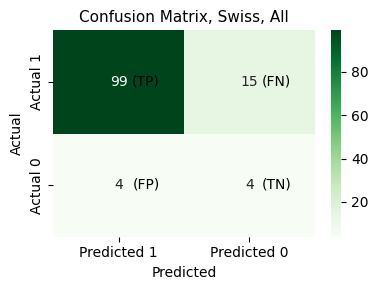

Predicted Overall Accuracy: 0.8442622950819673
Naive Rate, If all Positive: 0.9344262295081968
Naive Rate, If all Negative: 0.06557377049180328
True Positive Rate: 0.868421052631579
False Negative Rate: 0.13157894736842105
False Positive Rate: 0.5
True Negative Rate: 0.5
Precision: 0.9611650485436893
Negative Predictive Value: 0.21052631578947367


In [159]:
# Predict using set 1 logit
threshold = 0.5
switz_y_pred_lr_1 = (lr_1.predict(add_const(switz_X_1)) >= threshold).astype(int)
print("accuracy score", accuracy_score(switz_y_1,switz_y_pred_lr_1))
print("f1 score", f1_score(switz_y_1,switz_y_pred_lr_1))

# Predict using set 2 logit
threshold = 0.5
switz_y_pred_lr_2 = (lr_2.predict(add_const(switz_X_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(switz_y_2,switz_y_pred_lr_2))
print("f1 score", f1_score(switz_y_2,switz_y_pred_lr_2))

# Combine predictions
switz_y_pred_lr = np.concatenate((switz_y_pred_lr_1, switz_y_pred_lr_2), axis=0)
switz_y = np.concatenate((switz_y_1, switz_y_2), axis=0)
print("accuracy score", accuracy_score(switz_y,switz_y_pred_lr))
print("f1 score", f1_score(switz_y,switz_y_pred_lr))

# Output analysis and confusion matrix
cm_switz_lr = model_outputs(switz_y, switz_y_pred_lr, "Swiss, All")

Female Switerland

accuracy score 0.4
f1 score 0.5714285714285715


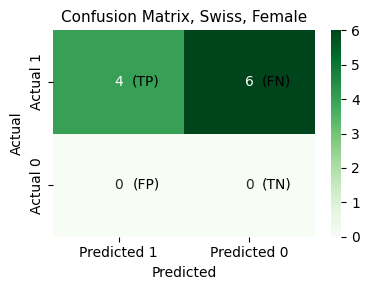

Predicted Overall Accuracy: 0.4
Naive Rate, If all Positive: 1.0
Naive Rate, If all Negative: 0.0
True Positive Rate: 0.4
False Negative Rate: 0.6
False Positive Rate: nan
True Negative Rate: nan
Precision: 1.0
Negative Predictive Value: 0.0


In [160]:
# Predict using set 1 logit
# No samples for set 1 female

# Predict using set 2 logit
threshold = 0.5
switz_y_pred_lr_f_2 = (lr_2.predict(add_const(switz_X_f_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(switz_y_f_2,switz_y_pred_lr_f_2))
print("f1 score", f1_score(switz_y_f_2,switz_y_pred_lr_f_2))

# Output analysis and confusion matrix
cm_switz_lr_f = model_outputs(switz_y_f_2, switz_y_pred_lr_f_2, "Swiss, Female")

Male Switerland

accuracy score 1.0
f1 score 1.0
accuracy score 0.8828828828828829
f1 score 0.9353233830845772
accuracy score 0.8839285714285714
f1 score 0.9359605911330049


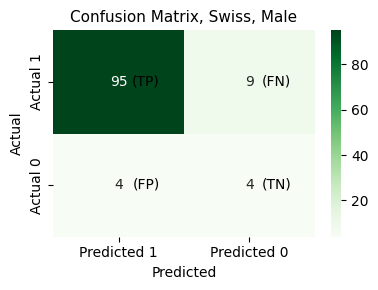

Predicted Overall Accuracy: 0.8839285714285714
Naive Rate, If all Positive: 0.9285714285714286
Naive Rate, If all Negative: 0.07142857142857142
True Positive Rate: 0.9134615384615384
False Negative Rate: 0.08653846153846154
False Positive Rate: 0.5
True Negative Rate: 0.5
Precision: 0.9595959595959596
Negative Predictive Value: 0.3076923076923077


In [161]:
# Predict using set 1 logit
threshold = 0.5
switz_y_pred_lr_m_1 = (lr_1.predict(add_const(switz_X_m_1)) >= threshold).astype(int)
print("accuracy score", accuracy_score(switz_y_m_1,switz_y_pred_lr_m_1))
print("f1 score", f1_score(switz_y_m_1,switz_y_pred_lr_m_1))

# Predict using set 2 logit
threshold = 0.5
switz_y_pred_lr_m_2 = (lr_2.predict(add_const(switz_X_m_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(switz_y_m_2,switz_y_pred_lr_m_2))
print("f1 score", f1_score(switz_y_m_2,switz_y_pred_lr_m_2))

# Combine predictions
switz_y_pred_lr_m = np.concatenate((switz_y_pred_lr_m_1, switz_y_pred_lr_m_2), axis=0)
switz_y_m = np.concatenate((switz_y_m_1, switz_y_m_2), axis=0)
print("accuracy score", accuracy_score(switz_y_m,switz_y_pred_lr_m))
print("f1 score", f1_score(switz_y_m,switz_y_pred_lr_m))

# Output analysis and confusion matrix
cm_switz_lr_m = model_outputs(switz_y_m, switz_y_pred_lr_m, "Swiss, Male")

#### Test on Hungarian

Overall Hungarian

accuracy score 1.0
f1 score 0.0
accuracy score 0.7671232876712328
f1 score 0.711864406779661
accuracy score 0.7679180887372014
f1 score 0.711864406779661


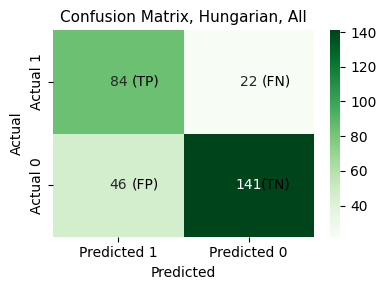

Predicted Overall Accuracy: 0.7679180887372014
Naive Rate, If all Positive: 0.36177474402730375
Naive Rate, If all Negative: 0.6382252559726962
True Positive Rate: 0.7924528301886793
False Negative Rate: 0.20754716981132076
False Positive Rate: 0.24598930481283424
True Negative Rate: 0.7540106951871658
Precision: 0.6461538461538462
Negative Predictive Value: 0.8650306748466258


In [162]:
# Predict using set 1 logit
threshold = 0.5
hung_y_pred_lr_1 = (lr_1.predict(add_const(hung_X_1)) >= threshold).astype(int)
print("accuracy score", accuracy_score(hung_y_1,hung_y_pred_lr_1))
print("f1 score", f1_score(hung_y_1,hung_y_pred_lr_1))

# Predict using set 2 logit
threshold = 0.5
hung_y_pred_lr_2 = (lr_2.predict(add_const(hung_X_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(hung_y_2,hung_y_pred_lr_2))
print("f1 score", f1_score(hung_y_2,hung_y_pred_lr_2))

# Combine predictions
hung_y_pred_lr = np.concatenate((hung_y_pred_lr_1, hung_y_pred_lr_2), axis=0)
hung_y = np.concatenate((hung_y_1, hung_y_2), axis=0)
print("accuracy score", accuracy_score(hung_y,hung_y_pred_lr))
print("f1 score", f1_score(hung_y,hung_y_pred_lr))

# Output analysis and confusion matrix
cm_hung_lr = model_outputs(hung_y, hung_y_pred_lr, "Hungarian, All")

Female Hungarian

accuracy score 1.0
f1 score 0.0
accuracy score 0.825
f1 score 0.3636363636363636
accuracy score 0.8271604938271605
f1 score 0.3636363636363636


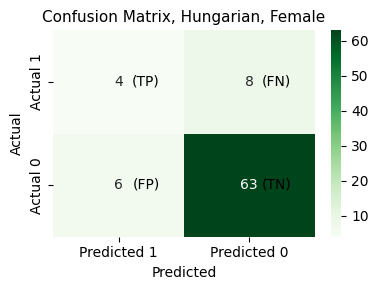

Predicted Overall Accuracy: 0.8271604938271605
Naive Rate, If all Positive: 0.14814814814814814
Naive Rate, If all Negative: 0.8518518518518519
True Positive Rate: 0.3333333333333333
False Negative Rate: 0.6666666666666666
False Positive Rate: 0.08695652173913043
True Negative Rate: 0.9130434782608695
Precision: 0.4
Negative Predictive Value: 0.8873239436619719


In [163]:
# Predict using set 1 logit
threshold = 0.5
hung_y_pred_lr_f_1 = (lr_1.predict(add_const(hung_X_f_1)) >= threshold).astype(int)
print("accuracy score", accuracy_score(hung_y_f_1,hung_y_pred_lr_f_1))
print("f1 score", f1_score(hung_y_f_1,hung_y_pred_lr_f_1))

# Predict using set 2 logit
threshold = 0.5
hung_y_pred_lr_f_2 = (lr_2.predict(add_const(hung_X_f_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(hung_y_f_2,hung_y_pred_lr_f_2))
print("f1 score", f1_score(hung_y_f_2,hung_y_pred_lr_f_2))

# Combine predictions
hung_y_pred_lr_f = np.concatenate((hung_y_pred_lr_f_1, hung_y_pred_lr_f_2), axis=0)
hung_y_f = np.concatenate((hung_y_f_1, hung_y_f_2), axis=0)
print("accuracy score", accuracy_score(hung_y_f,hung_y_pred_lr_f))
print("f1 score", f1_score(hung_y_f,hung_y_pred_lr_f))

# Output analysis and confusion matrix
cm_hung_lr_f = model_outputs(hung_y_f, hung_y_pred_lr_f, "Hungarian, Female")

Male Hungarian

accuracy score 0.7452830188679245
f1 score 0.7476635514018691


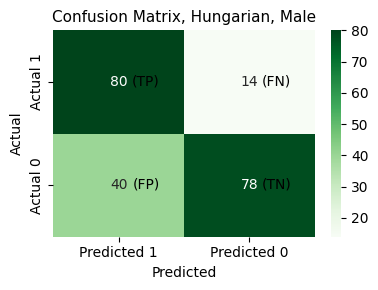

Predicted Overall Accuracy: 0.7452830188679245
Naive Rate, If all Positive: 0.44339622641509435
Naive Rate, If all Negative: 0.5566037735849056
True Positive Rate: 0.851063829787234
False Negative Rate: 0.14893617021276595
False Positive Rate: 0.3389830508474576
True Negative Rate: 0.6610169491525424
Precision: 0.6666666666666666
Negative Predictive Value: 0.8478260869565217


In [164]:
# Predict using set 1 logit
# No samples for set 1 male

# Predict using set 2 logit
threshold = 0.5
hung_y_pred_lr_m_2 = (lr_2.predict(add_const(hung_X_m_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(hung_y_m_2,hung_y_pred_lr_m_2))
print("f1 score", f1_score(hung_y_m_2,hung_y_pred_lr_m_2))

# Output analysis and confusion matrix
cm_hung_lr_m = model_outputs(hung_y_m_2, hung_y_pred_lr_m_2, "Hungarian, Male")

#### Test on VA

Overall VA

accuracy score 0.7547169811320755
f1 score 0.8219178082191781
accuracy score 0.7602739726027398
f1 score 0.8547717842323652
accuracy score 0.7587939698492462
f1 score 0.8471337579617835


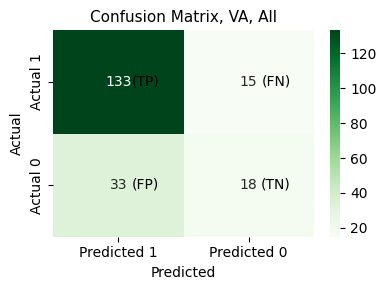

Predicted Overall Accuracy: 0.7587939698492462
Naive Rate, If all Positive: 0.7437185929648241
Naive Rate, If all Negative: 0.2562814070351759
True Positive Rate: 0.8986486486486487
False Negative Rate: 0.10135135135135136
False Positive Rate: 0.6470588235294118
True Negative Rate: 0.35294117647058826
Precision: 0.8012048192771084
Negative Predictive Value: 0.5454545454545454


In [165]:
# Predict using set 1 logit
threshold = 0.5
va_y_pred_lr_1 = (lr_1.predict(add_const(va_X_1)) >= threshold).astype(int)
print("accuracy score", accuracy_score(va_y_1,va_y_pred_lr_1))
print("f1 score", f1_score(va_y_1,va_y_pred_lr_1))

# Predict using set 2 logit
threshold = 0.5
va_y_pred_lr_2 = (lr_2.predict(add_const(va_X_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(va_y_2,va_y_pred_lr_2))
print("f1 score", f1_score(va_y_2,va_y_pred_lr_2))


# Combine predictions
va_y_pred_lr = np.concatenate((va_y_pred_lr_1, va_y_pred_lr_2), axis=0)
va_y = np.concatenate((va_y_1, va_y_2), axis=0)
print("accuracy score", accuracy_score(va_y,va_y_pred_lr))
print("f1 score", f1_score(va_y,va_y_pred_lr))

# Output analysis and confusion matrix
cm_va_lr = model_outputs(va_y, va_y_pred_lr, "VA, All")

Female VA

accuracy score 1.0
f1 score 0.0
accuracy score 0.6
f1 score 0.6666666666666666
accuracy score 0.6666666666666666
f1 score 0.6666666666666666


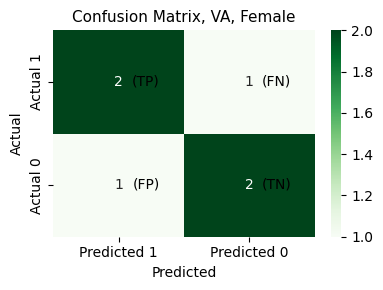

Predicted Overall Accuracy: 0.6666666666666666
Naive Rate, If all Positive: 0.5
Naive Rate, If all Negative: 0.5
True Positive Rate: 0.6666666666666666
False Negative Rate: 0.3333333333333333
False Positive Rate: 0.3333333333333333
True Negative Rate: 0.6666666666666666
Precision: 0.6666666666666666
Negative Predictive Value: 0.6666666666666666


In [166]:
# Predict using set 1 logit
threshold = 0.5
va_y_pred_lr_f_1 = (lr_1.predict(add_const(va_X_f_1)) >= threshold).astype(int)
print("accuracy score", accuracy_score(va_y_f_1,va_y_pred_lr_f_1))
print("f1 score", f1_score(va_y_f_1,va_y_pred_lr_f_1))

# Predict using set 2 logit
threshold = 0.5
va_y_pred_lr_f_2 = (lr_2.predict(add_const(va_X_f_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(va_y_f_2,va_y_pred_lr_f_2))
print("f1 score", f1_score(va_y_f_2,va_y_pred_lr_f_2))

# Combine predictions
va_y_pred_lr_f = np.concatenate((va_y_pred_lr_f_1, va_y_pred_lr_f_2), axis=0)
va_y_f = np.concatenate((va_y_f_1, va_y_f_2), axis=0)
print("accuracy score", accuracy_score(va_y_f,va_y_pred_lr_f))
print("f1 score", f1_score(va_y_f,va_y_pred_lr_f))

# Output analysis and confusion matrix
cm_va_lr_f = model_outputs(va_y_f, va_y_pred_lr_f, "VA, Female")

Male VA

accuracy score 0.75
f1 score 0.8219178082191781
accuracy score 0.7659574468085106
f1 score 0.8595744680851065
accuracy score 0.7616580310880829
f1 score 0.8506493506493507


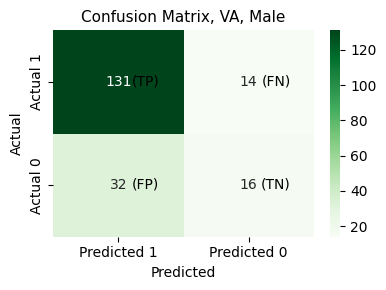

Predicted Overall Accuracy: 0.7616580310880829
Naive Rate, If all Positive: 0.7512953367875648
Naive Rate, If all Negative: 0.24870466321243523
True Positive Rate: 0.903448275862069
False Negative Rate: 0.09655172413793103
False Positive Rate: 0.6666666666666666
True Negative Rate: 0.3333333333333333
Precision: 0.803680981595092
Negative Predictive Value: 0.5333333333333333


In [167]:
# Predict using set 1 logit
threshold = 0.5
va_y_pred_lr_m_1 = (lr_1.predict(add_const(va_X_m_1)) >= threshold).astype(int)
print("accuracy score", accuracy_score(va_y_m_1,va_y_pred_lr_m_1))
print("f1 score", f1_score(va_y_m_1,va_y_pred_lr_m_1))

# Predict using set 2 logit
threshold = 0.5
va_y_pred_lr_m_2 = (lr_2.predict(add_const(va_X_m_2)) >= threshold).astype(int)
print("accuracy score", accuracy_score(va_y_m_2,va_y_pred_lr_m_2))
print("f1 score", f1_score(va_y_m_2,va_y_pred_lr_m_2))

# Combine predictions
va_y_pred_lr_m = np.concatenate((va_y_pred_lr_m_1, va_y_pred_lr_m_2), axis=0)
va_y_m = np.concatenate((va_y_m_1, va_y_m_2), axis=0)
print("accuracy score", accuracy_score(va_y_m,va_y_pred_lr_m))
print("f1 score", f1_score(va_y_m,va_y_pred_lr_m))

# Output analysis and confusion matrix
cm_va_lr_m = model_outputs(va_y_m, va_y_pred_lr_m, "VA, Male")

## Stratified Sampling

In [168]:
# Combine
comb_raw = pd.concat([clev_data, hung_data], ignore_index=True)
comb_raw.reset_index(drop=True, inplace=True)
comb_raw

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
1    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
2    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
3    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
4    56.0  1.0  2.0     120.0  236.0  0.0      0.0    178.0    0.0      0.8   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
590  52.0  1.0  4.0     160.0  331.0  0.0      0.0     94.0    1.0      2.5   
591  54.0  0.0  3.0     130.0  294.0  0.0      1.0    100.0    1.0      0.0   
592  56.0  1.0  4.0     155.0  342.0  1.0      0.0    150.0    1.0      3.0   
593  58.0  0.0  2.0     180.0  393.0  0.0      0.0    110.0    1.0      1.0   
594  65.0  1.0  4.0     130.0  275.0  0.0      1.0    115.0    1.0      1.0   

     slope   ca  thal  target  
0      2.0  3.0   3.0       1  
1      2.0  2.0   7.0       1  
2      3.0  0.0   3.0       0  
3      1.0  0.0   3.0       0  
4      1.0  0.0   3.0       0  
..     ...  ...   ...     ...  
590    NaN  NaN   NaN       1  
591    2.0  NaN   NaN       1  
592    2.0  NaN   NaN       1  
593    2.0  NaN   7.0       1  
594    2.0  NaN   NaN       1  

[595 rows x 14 columns]

In [169]:
# Only 1 sample seems to have null values for 'thalach' and 'exang'
print(comb_raw.isnull().sum())
print(comb_raw.index[comb_raw['thalach'].isnull()])
print(comb_raw.index[comb_raw['exang'].isnull()])

age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalach       1
exang         1
oldpeak       0
slope       189
ca          294
thal        267
target        0
dtype: int64
Index([391], dtype='int64')
Index([391], dtype='int64')


In [170]:
# Dropping that row
comb_raw = comb_raw.drop(comb_raw.index[comb_raw['exang'].isnull()].tolist())

In [171]:
# Count for sex and target combinations
count_sex0_target1 = ((comb_raw['sex'] == 0) & (comb_raw['target'] == 1)).sum()
count_sex0_target0 = ((comb_raw['sex'] == 0) & (comb_raw['target'] == 0)).sum()
count_sex1_target1 = ((comb_raw['sex'] == 1) & (comb_raw['target'] == 1)).sum()
count_sex1_target0 = ((comb_raw['sex'] == 1) & (comb_raw['target'] == 0)).sum()

# Print
print("Count of rows where sex == 0 & target == 1:", count_sex0_target1)
print("Count of rows where sex == 0 & target == 0:", count_sex0_target0)
print("Count of rows where sex == 1 & target == 1:", count_sex1_target1)
print("Count of rows where sex == 1 & target == 0:", count_sex1_target0)

# Given prevalence is ~20% for both sexes, looks like sex == 0 (female) and target == 0 (no heart disease) is the sample size limitation

Count of rows where sex == 0 & target == 1: 37
Count of rows where sex == 0 & target == 0: 140
Count of rows where sex == 1 & target == 1: 208
Count of rows where sex == 1 & target == 0: 209


In [172]:
# Set seed for replicability
np.random.seed(42)

# Sample without replacement; 35 / (35+140) = 20%
sampled_sex0_target1 = comb_raw[(comb_raw['sex'] == 0) & (comb_raw['target'] == 1)].sample(n=35, replace=False)
sampled_sex0_target0 = comb_raw[(comb_raw['sex'] == 0) & (comb_raw['target'] == 0)].sample(n=140, replace=False)
sampled_sex1_target1 = comb_raw[(comb_raw['sex'] == 1) & (comb_raw['target'] == 1)].sample(n=35, replace=False)
sampled_sex1_target0 = comb_raw[(comb_raw['sex'] == 1) & (comb_raw['target'] == 0)].sample(n=140, replace=False)

# Combine the sampled DataFrames
strat_data = pd.concat([sampled_sex0_target1, sampled_sex0_target0, sampled_sex1_target1, sampled_sex1_target0], ignore_index=True)
strat_data

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  0.0  4.0     108.0  269.0  0.0      0.0    169.0    1.0      1.8   
1    60.0  0.0  4.0     158.0  305.0  0.0      2.0    161.0    0.0      0.0   
2    62.0  0.0  4.0     160.0  164.0  0.0      2.0    145.0    0.0      6.2   
3    59.0  0.0  4.0     130.0  338.0  1.0      1.0    130.0    1.0      1.5   
4    54.0  0.0  3.0     130.0  294.0  0.0      1.0    100.0    1.0      0.0   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
345  39.0  1.0  4.0     110.0  273.0  0.0      0.0    132.0    0.0      0.0   
346  41.0  1.0  2.0     120.0  295.0  0.0      0.0    170.0    0.0      0.0   
347  33.0  1.0  3.0     120.0  298.0  0.0      0.0    185.0    0.0      0.0   
348  45.0  1.0  4.0     115.0  260.0  0.0      2.0    185.0    0.0      0.0   
349  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   

     slope   ca  thal  target  
0      2.0  2.0   3.0       1  
1      1.0  0.0   3.0       1  
2      3.0  3.0   7.0       1  
3      2.0  NaN   NaN       1  
4      2.0  NaN   NaN       1  
..     ...  ...   ...     ...  
345    NaN  NaN   NaN       0  
346    NaN  NaN   NaN       0  
347    NaN  NaN   NaN       0  
348    1.0  0.0   3.0       0  
349    3.0  0.0   3.0       0  

[350 rows x 14 columns]

In [173]:
# Sensitive Groups split: sex - female and male
strat_rows_f = strat_data.index[strat_data['sex'] == 0].tolist()
strat_data_f = strat_data.loc[strat_rows_f]
strat_data_m = strat_data.drop(strat_rows_f)

In [174]:
strat_stats = strat_data.describe().round(2)
median_values = strat_data.median()
strat_stats.loc['median'] = median_values
print(f'Stratified Overall: Mean, Median, Standard Deviation of Variables')
strat_stats

Stratified Overall: Mean, Median, Standard Deviation of Variables


age    sex      cp  trestbps    chol    fbs  restecg  thalach  \
count   350.00  350.0  350.00    350.00  336.00  346.0   349.00   350.00   
mean     51.04    0.5    2.93    131.39  246.45    0.1     0.61   148.13   
std       8.97    0.5    0.93     17.62   57.93    0.3     0.86    22.56   
min      29.00    0.0    1.00     94.00   85.00    0.0     0.00    90.00   
25%      44.00    0.0    2.00    120.00  208.00    0.0     0.00   133.00   
50%      52.00    0.5    3.00    130.00  239.00    0.0     0.00   150.00   
75%      57.00    1.0    4.00    140.00  275.50    0.0     2.00   165.00   
max      76.00    1.0    4.00    200.00  564.00    1.0     2.00   202.00   
median   52.00    0.5    3.00    130.00  239.00    0.0     0.00   150.00   

         exang  oldpeak   slope      ca    thal  target  
count   350.00   350.00  225.00  181.00  198.00   350.0  
mean      0.22     0.62    1.62    0.49    4.22     0.2  
std       0.42     0.96    0.61    0.88    1.79     0.4  
min       0.00     0.00    1.00    0.00    3.00     0.0  
25%       0.00     0.00    1.00    0.00    3.00     0.0  
50%       0.00     0.00    2.00    0.00    3.00     0.0  
75%       0.00     1.00    2.00    1.00    6.75     0.0  
max       1.00     6.20    3.00    3.00    7.00     1.0  
median    0.00     0.00    2.00    0.00    3.00     0.0

In [175]:
strat_stats_f = strat_data_f.describe().round(2)
median_values = strat_data_f.median()
strat_stats_f.loc['median'] = median_values
print(f'Stratified Female: Mean, Median, Standard Deviation of Variables')
strat_stats_f

Stratified Female: Mean, Median, Standard Deviation of Variables


age    sex      cp  trestbps    chol     fbs  restecg  thalach  \
count   175.00  175.0  175.00    175.00  168.00  171.00   175.00   175.00   
mean     52.02    0.0    2.89    131.65  254.84    0.09     0.66   147.93   
std       9.42    0.0    0.92     18.82   64.21    0.28     0.87    21.49   
min      30.00    0.0    1.00     94.00  141.00    0.00     0.00    90.00   
25%      45.00    0.0    2.00    120.00  209.75    0.00     0.00   132.00   
50%      52.00    0.0    3.00    130.00  244.50    0.00     0.00   150.00   
75%      58.00    0.0    4.00    140.00  289.50    0.00     2.00   163.00   
max      76.00    0.0    4.00    200.00  564.00    1.00     2.00   192.00   
median   52.00    0.0    3.00    130.00  244.50    0.00     0.00   150.00   

         exang  oldpeak   slope     ca    thal  target  
count   175.00   175.00  120.00  96.00  102.00   175.0  
mean      0.21     0.64    1.61   0.52    3.82     0.2  
std       0.41     0.96    0.57   0.85    1.59     0.4  
min       0.00     0.00    1.00   0.00    3.00     0.0  
25%       0.00     0.00    1.00   0.00    3.00     0.0  
50%       0.00     0.00    2.00   0.00    3.00     0.0  
75%       0.00     1.00    2.00   1.00    3.00     0.0  
max       1.00     6.20    3.00   3.00    7.00     1.0  
median    0.00     0.00    2.00   0.00    3.00     0.0

In [176]:
strat_stats_m = strat_data_m.describe().round(2)
median_values = strat_data_m.median()
strat_stats_m.loc['median'] = median_values
print(f'Stratified Male: Mean, Median, Standard Deviation of Variables')
strat_stats_m

Stratified Male: Mean, Median, Standard Deviation of Variables


age    sex      cp  trestbps    chol     fbs  restecg  thalach  \
count   175.00  175.0  175.00    175.00  168.00  175.00   174.00   175.00   
mean     50.06    1.0    2.97    131.14  238.05    0.11     0.56   148.34   
std       8.40    0.0    0.95     16.38   49.67    0.31     0.86    23.65   
min      29.00    1.0    1.00     94.00   85.00    0.00     0.00    92.00   
25%      44.00    1.0    2.00    120.00  207.00    0.00     0.00   135.00   
50%      51.00    1.0    3.00    130.00  234.50    0.00     0.00   150.00   
75%      56.00    1.0    4.00    140.00  265.00    0.00     1.00   168.00   
max      70.00    1.0    4.00    192.00  412.00    1.00     2.00   202.00   
median   51.00    1.0    3.00    130.00  234.50    0.00     0.00   150.00   

         exang  oldpeak   slope     ca   thal  target  
count   175.00   175.00  105.00  85.00  96.00   175.0  
mean      0.24     0.59    1.63   0.45   4.65     0.2  
std       0.43     0.95    0.65   0.92   1.90     0.4  
min       0.00     0.00    1.00   0.00   3.00     0.0  
25%       0.00     0.00    1.00   0.00   3.00     0.0  
50%       0.00     0.00    2.00   0.00   3.00     0.0  
75%       0.00     1.00    2.00   0.00   7.00     0.0  
max       1.00     4.40    3.00   3.00   7.00     1.0  
median    0.00     0.00    2.00   0.00   3.00     0.0

### Stratified Logistic Regression

In [177]:
# calling Logistic Regression
lr_s_1 = LogisticRegression(max_iter=1000)
lr_s_2 = LogisticRegression(max_iter=1000)

In [178]:
# fitting train data - without thalach and exang
strat_y = strat_data['target']
strat_X_1 = strat_data[feature_cols_1]
lr_s_1.fit(strat_X_1, strat_y)

LogisticRegression(max_iter=1000)

In [179]:
lr_s_1.coef_

array([[0.05110337, 0.00967563, 1.31005826]])

In [180]:
# fitting train data - without thalach and exang
strat_X_2 = strat_data[feature_cols_2]
lr_s_2.fit(strat_X_2, strat_y)

LogisticRegression(max_iter=1000)

In [181]:
lr_s_2.coef_

array([[ 0.04561714, -0.05474405,  0.92650551, -0.00814826,  1.60621068]])

In [182]:
# Logistic Regression for Swiss Data (all datapoints) for feature sets 1 and 2
switz_y_pred_lr_s_1 = lr_s_1.predict(switz_X_1)
print("accuracy score", accuracy_score(switz_y_1, switz_y_pred_lr_s_1))
print("f1 score", f1_score(switz_y_1, switz_y_pred_lr_s_1))
switz_y_pred_lr_s_2 = lr_s_2.predict(switz_X_2)
print("accuracy score", accuracy_score(switz_y_2, switz_y_pred_lr_s_2))
print("f1 score", f1_score(switz_y_2, switz_y_pred_lr_s_2))
switz_y_pred_lr_s = np.concatenate((switz_y_pred_lr_s_1, switz_y_pred_lr_s_2), axis=0)
switz_y = np.concatenate((switz_y_1, switz_y_2), axis=0)
print("accuracy score", accuracy_score(switz_y, switz_y_pred_lr_s))
print("f1 score", f1_score(switz_y, switz_y_pred_lr_s))
#print(accuracy_score(switz_y, switz_y_pred_lr_s))

accuracy score 1.0
f1 score 1.0
accuracy score 0.4214876033057851
f1 score 0.5569620253164557
accuracy score 0.4262295081967213
f1 score 0.5625


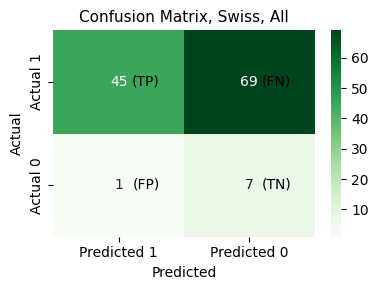

Naive Rate, Predict Negative: 0.06557377049180328
True Positive Rate: 0.39473684210526316
False Negative Rate: 0.6052631578947368
False Positive Rate: 0.125
True Negative Rate: 0.875
Precision: 0.9782608695652174
Negative Predictive Value: 0.09210526315789473
accuracy score 0.4262295081967213
f1 score 0.5625


In [183]:
# Confusion Matrix for Swiss Data (all datapoints) for feature sets 1 and 2
cm = confusion_matrix(1-switz_y, 1-switz_y_pred_lr_s)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Swiss, All', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())
print("accuracy score", accuracy_score(switz_y, switz_y_pred_lr_s))
print("f1 score", f1_score(switz_y, switz_y_pred_lr_s))

In [184]:
# Logistic Regression for Swiss Data (female datapoints only) for feature sets 1 and 2
# no female datapoints for set 1 in the dataset

switz_y_pred_lr_s_f_2 = lr_s_2.predict(switz_X_f_2)
print("accuracy score", accuracy_score(switz_y_f_2, switz_y_pred_lr_s_f_2))
print("f1 score", f1_score(switz_y_f_2, switz_y_pred_lr_s_f_2))


accuracy score 0.3
f1 score 0.4615384615384615


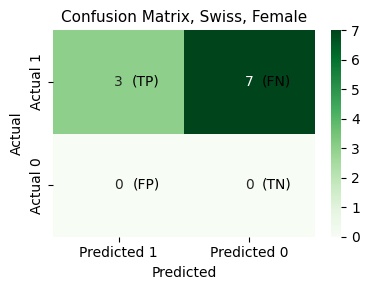

Naive Rate, Predict Negative: 0.0
True Positive Rate: 0.3
False Negative Rate: 0.7
False Positive Rate: nan
True Negative Rate: nan
Precision: 1.0
Negative Predictive Value: 0.0
accuracy score 0.3
f1 score 0.4615384615384615


In [185]:
# Confusion Matrix for Swiss Data (female datapoints only) for feature sets 1 and 2
# no female datapoints for set 1 in the dataset
cm = confusion_matrix(1-switz_y_f_2, 1-switz_y_pred_lr_s_f_2)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Swiss, Female', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())


#switz_y_pred_lr_f_1 = (lr_1.predict(add_const(switz_X_f_1)) >= threshold).astype(int)
switz_y_pred_lr_f_2 = (lr_2.predict(add_const(switz_X_f_2)) >= threshold).astype(int)
#switz_y_pred_lr_f = np.concatenate((switz_y_pred_lr_f_1, switz_y_pred_lr_f_2), axis=0)
#switz_y_f = np.concatenate((switz_y_f_1, switz_y_f_2), axis=0)
#print(accuracy_score(switz_y_f_2, switz_y_pred_lr_f_2))
print("accuracy score", accuracy_score(switz_y_f_2, switz_y_pred_lr_s_f_2))
print("f1 score", f1_score(switz_y_f_2, switz_y_pred_lr_s_f_2))

In [186]:
# Logistic Regression for Swiss Data (male datapoints only) for feature sets 1 and 2

switz_y_pred_lr_s_m_1 = lr_s_1.predict(switz_X_m_1)
print("accuracy score", accuracy_score(switz_y_m_1, switz_y_pred_lr_s_m_1))
print("f1 score", f1_score(switz_y_m_1, switz_y_pred_lr_s_m_1))
switz_y_pred_lr_s_m_2 = lr_s_2.predict(switz_X_m_2)
print("accuracy score", accuracy_score(switz_y_m_2, switz_y_pred_lr_s_m_2))
print("f1 score", f1_score(switz_y_m_2, switz_y_pred_lr_s_m_2))
switz_y_pred_lr_s_m = np.concatenate((switz_y_pred_lr_s_m_1, switz_y_pred_lr_s_m_2), axis=0)
switz_y_m = np.concatenate((switz_y_m_1, switz_y_m_2), axis=0)
print("accuracy score", accuracy_score(switz_y_m, switz_y_pred_lr_s_m))
print("f1 score", f1_score(switz_y_m, switz_y_pred_lr_s_m))
#print(accuracy_score(switz_y_m, switz_y_pred_lr_s_m))

accuracy score 1.0
f1 score 1.0
accuracy score 0.43243243243243246
f1 score 0.5655172413793104
accuracy score 0.4375
f1 score 0.5714285714285714


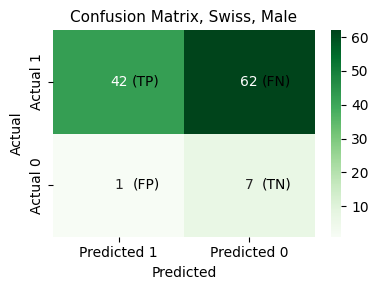

Naive Rate, Predict Negative: 0.07142857142857142
True Positive Rate: 0.40384615384615385
False Negative Rate: 0.5961538461538461
False Positive Rate: 0.125
True Negative Rate: 0.875
Precision: 0.9767441860465116
Negative Predictive Value: 0.10144927536231885
accuracy score 0.4375
f1 score 0.5714285714285714


In [187]:
# Confusion Matrix for Swiss Data (male datapoints only) for feature sets 1 and 2

cm = confusion_matrix(1-switz_y_m, 1-switz_y_pred_lr_s_m)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Swiss, Male', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())

switz_y_pred_lr_m_1 = (lr_1.predict(add_const(switz_X_m_1)) >= threshold).astype(int)
switz_y_pred_lr_m_2 = (lr_2.predict(add_const(switz_X_m_2)) >= threshold).astype(int)
switz_y_pred_lr_m = np.concatenate((switz_y_pred_lr_m_1, switz_y_pred_lr_m_2), axis=0)
switz_y_m = np.concatenate((switz_y_m_1, switz_y_m_2), axis=0)
#print(accuracy_score(switz_y_m, switz_y_pred_lr_m))
print("accuracy score", accuracy_score(switz_y_m, switz_y_pred_lr_s_m))
print("f1 score", f1_score(switz_y_m, switz_y_pred_lr_s_m))

In [188]:
# Logistic Regression for Hungarian Data (all datapoints) for feature sets 1 and 2
hung_y_pred_lr_s_1 = lr_s_1.predict(hung_X_1)
print("accuracy score", accuracy_score(hung_y_1, hung_y_pred_lr_s_1))
print("f1 score", f1_score(hung_y_1, hung_y_pred_lr_s_1))
hung_y_pred_lr_s_2 = lr_s_2.predict(hung_X_2)
print("accuracy score", accuracy_score(hung_y_2, hung_y_pred_lr_s_2))
print("f1 score", f1_score(hung_y_2, hung_y_pred_lr_s_2))
hung_y_pred_lr_s = np.concatenate((hung_y_pred_lr_s_1, hung_y_pred_lr_s_2), axis=0)
hung_y = np.concatenate((hung_y_1, hung_y_2), axis=0)
print("accuracy score", accuracy_score(hung_y, hung_y_pred_lr_s))
print("f1 score", f1_score(hung_y, hung_y_pred_lr_s))
#print(accuracy_score(hung_y, hung_y_pred_lr_s))


accuracy score 1.0
f1 score 0.0
accuracy score 0.7808219178082192
f1 score 0.6235294117647059
accuracy score 0.7815699658703071
f1 score 0.6235294117647059


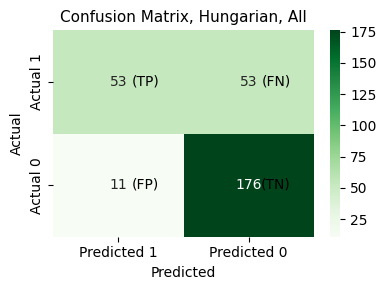

Naive Rate, Predict Negative: 0.6382252559726962
True Positive Rate: 0.5
False Negative Rate: 0.5
False Positive Rate: 0.058823529411764705
True Negative Rate: 0.9411764705882353
Precision: 0.828125
Negative Predictive Value: 0.7685589519650655
accuracy score 0.7815699658703071
f1 score 0.6235294117647059


In [189]:
# Confusion Matrix for Hungarian Data (all datapoints) for feature sets 1 and 2
cm = confusion_matrix(1-hung_y, 1-hung_y_pred_lr_s)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Hungarian, All', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())
print("accuracy score", accuracy_score(hung_y, hung_y_pred_lr_s))
print("f1 score", f1_score(hung_y, hung_y_pred_lr_s))

In [190]:
# Logistic Regression for Hungarian Data (female datapoints) for feature sets 1 and 2
hung_y_pred_lr_s_f_1 = lr_s_1.predict(hung_X_f_1)
print("accuracy score", accuracy_score(hung_y_f_1, hung_y_pred_lr_s_f_1))
print("f1 score", f1_score(hung_y_f_1, hung_y_pred_lr_s_f_1))
hung_y_pred_lr_s_f_2 = lr_s_2.predict(hung_X_f_2)
print("accuracy score", accuracy_score(hung_y_f_2, hung_y_pred_lr_s_f_2))
print("f1 score", f1_score(hung_y_f_2, hung_y_pred_lr_s_f_2))
hung_y_pred_lr_s_f = np.concatenate((hung_y_pred_lr_s_f_1, hung_y_pred_lr_s_f_2), axis=0)
hung_y_f = np.concatenate((hung_y_f_1, hung_y_f_2), axis=0)
print("accuracy score", accuracy_score(hung_y_f, hung_y_pred_lr_s_f))
print("f1 score", f1_score(hung_y_f, hung_y_pred_lr_s_f))
#print(accuracy_score(hung_y_f, hung_y_pred_lr_s_f))


accuracy score 1.0
f1 score 0.0
accuracy score 0.8375
f1 score 0.380952380952381
accuracy score 0.8395061728395061
f1 score 0.380952380952381


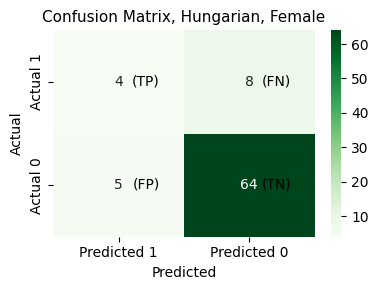

Naive Rate, Predict Negative: 0.8518518518518519
True Positive Rate: 0.3333333333333333
False Negative Rate: 0.6666666666666666
False Positive Rate: 0.07246376811594203
True Negative Rate: 0.927536231884058
Precision: 0.4444444444444444
Negative Predictive Value: 0.8888888888888888
accuracy score 0.8395061728395061
f1 score 0.380952380952381


In [191]:
# Confusion Matrix for Hungarian Data (female datapoints) for feature sets 1 and 2
cm = confusion_matrix(1-hung_y_f, 1-hung_y_pred_lr_s_f)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Hungarian, Female', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())

hung_y_pred_lr_f_1 = (lr_1.predict(add_const(hung_X_f_1)) >= threshold).astype(int)
hung_y_pred_lr_f_2 = (lr_2.predict(add_const(hung_X_f_2)) >= threshold).astype(int)
hung_y_pred_lr_f = np.concatenate((hung_y_pred_lr_f_1, hung_y_pred_lr_f_2), axis=0)
hung_y_f = np.concatenate((hung_y_f_1, hung_y_f_2), axis=0)
print("accuracy score", accuracy_score(hung_y_f, hung_y_pred_lr_s_f))
print("f1 score", f1_score(hung_y_f, hung_y_pred_lr_s_f))
#print(accuracy_score(hung_y_f, hung_y_pred_lr_f))

In [192]:
# Logistic Regression for Hungarian Data (male datapoints) for feature sets 1 and 2
# no male datapoints for set 1 in the dataset
hung_y_pred_lr_s_m_2 = lr_s_2.predict(hung_X_m_2)
print("accuracy score", accuracy_score(hung_y_m_2, hung_y_pred_lr_s_m_2))
print("f1 score", f1_score(hung_y_m_2, hung_y_pred_lr_s_m_2))

accuracy score 0.7594339622641509
f1 score 0.6577181208053692


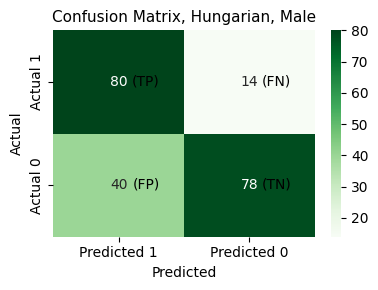

Naive Rate, Predict Negative: 0.5566037735849056
True Positive Rate: 0.851063829787234
False Negative Rate: 0.14893617021276595
False Positive Rate: 0.3389830508474576
True Negative Rate: 0.6610169491525424
Precision: 0.6666666666666666
Negative Predictive Value: 0.8478260869565217
accuracy score 0.7594339622641509
f1 score 0.6577181208053692


In [193]:
# Confusion Matrix for Hungarian Data (male datapoints) for feature sets 1 and 2
# no male datapoints for set 1 in the dataset
cm = confusion_matrix(1-hung_y_m_2, 1-hung_y_pred_lr_m_2)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Hungarian, Male', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())

#hung_y_pred_lr_m_1 = (lr_1.predict(add_const(hung_X_m_1)) >= threshold).astype(int)
hung_y_pred_lr_m_2 = (lr_2.predict(add_const(hung_X_m_2)) >= threshold).astype(int)
#hung_y_pred_lr_m = np.concatenate((hung_y_pred_lr_m_1, hung_y_pred_lr_m_2), axis=0)
#hung_y_m = np.concatenate((hung_y_m_1, hung_y_m_2), axis=0)
#print(accuracy_score(hung_y_m_2, hung_y_pred_lr_m_2))
print("accuracy score", accuracy_score(hung_y_m_2, hung_y_pred_lr_s_m_2))
print("f1 score", f1_score(hung_y_m_2, hung_y_pred_lr_s_m_2))

In [194]:
# Logistic Regression for VA LongBeach Data (all datapoints) for feature sets 1 and 2
va_y_pred_lr_s_1 = lr_s_1.predict(va_X_1)
print("accuracy score", accuracy_score(va_y_1, va_y_pred_lr_s_1))
print("f1 score", f1_score(va_y_1, va_y_pred_lr_s_1))
va_y_pred_lr_s_2 = lr_s_2.predict(va_X_2)
print("accuracy score", accuracy_score(va_y_2, va_y_pred_lr_s_2))
print("f1 score", f1_score(va_y_2, va_y_pred_lr_s_2))
va_y_pred_lr_s = np.concatenate((va_y_pred_lr_s_1, va_y_pred_lr_s_2), axis=0)
va_y = np.concatenate((va_y_1, va_y_2), axis=0)
print("accuracy score", accuracy_score(va_y, va_y_pred_lr_s))
print("f1 score", f1_score(va_y, va_y_pred_lr_s))
#print(accuracy_score(va_y, va_y_pred_lr_s))


accuracy score 0.5471698113207547
f1 score 0.45454545454545453
accuracy score 0.6575342465753424
f1 score 0.7422680412371133
accuracy score 0.628140703517588
f1 score 0.6890756302521008


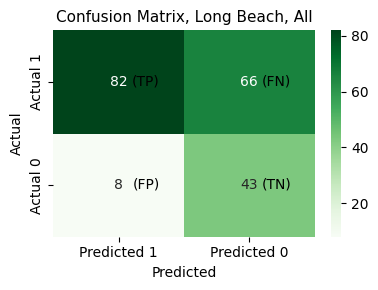

Naive Rate, Predict Negative: 0.2562814070351759
True Positive Rate: 0.5540540540540541
False Negative Rate: 0.44594594594594594
False Positive Rate: 0.1568627450980392
True Negative Rate: 0.8431372549019608
Precision: 0.9111111111111111
Negative Predictive Value: 0.3944954128440367
accuracy score 0.628140703517588
f1 score 0.6890756302521008


In [195]:
# Confusion Matrix for VA LongBeach Data (all datapoints) for feature sets 1 and 2
cm = confusion_matrix(1-va_y, 1-va_y_pred_lr_s)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Long Beach, All', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())
print("accuracy score", accuracy_score(va_y, va_y_pred_lr_s))
print("f1 score", f1_score(va_y, va_y_pred_lr_s))

In [196]:
# Logistic Regression for VA LongBeach Data (female datapoints) for feature sets 1 and 2
va_y_pred_lr_s_f_1 = lr_s_1.predict(va_X_f_1)
print("accuracy score", accuracy_score(va_y_f_1, va_y_pred_lr_s_f_1))
print("f1 score", f1_score(va_y_f_1, va_y_pred_lr_s_f_1))
va_y_pred_lr_s_f_2 = lr_s_2.predict(va_X_f_2)
print("accuracy score", accuracy_score(va_y_f_2, va_y_pred_lr_s_f_2))
print("f1 score", f1_score(va_y_f_2, va_y_pred_lr_s_f_2))
va_y_pred_lr_s_f = np.concatenate((va_y_pred_lr_s_f_1, va_y_pred_lr_s_f_2), axis=0)
va_y_f = np.concatenate((va_y_f_1, va_y_f_2), axis=0)
print("accuracy score", accuracy_score(va_y_f, va_y_pred_lr_s_f))
print("f1 score", f1_score(va_y_f, va_y_pred_lr_s_f))
#print(accuracy_score(va_y_f, va_y_pred_lr_s_f))


accuracy score 1.0
f1 score 0.0
accuracy score 0.8
f1 score 0.8
accuracy score 0.8333333333333334
f1 score 0.8


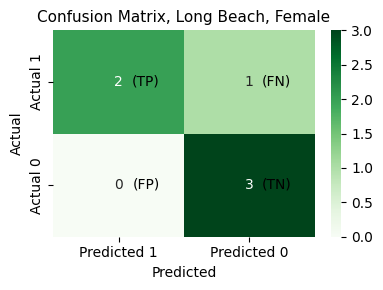

Naive Rate, Predict Negative: 0.5
True Positive Rate: 0.6666666666666666
False Negative Rate: 0.3333333333333333
False Positive Rate: 0.0
True Negative Rate: 1.0
Precision: 1.0
Negative Predictive Value: 0.75
accuracy score 0.8333333333333334
f1 score 0.8


In [197]:
# Confusion Matrix for VA LongBeach Data (female datapoints) for feature sets 1 and 2
cm = confusion_matrix(1-va_y_f, 1-va_y_pred_lr_s_f)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Long Beach, Female', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())

va_y_pred_lr_f_1 = (lr_1.predict(add_const(va_X_f_1)) >= threshold).astype(int)
va_y_pred_lr_f_2 = (lr_2.predict(add_const(va_X_f_2)) >= threshold).astype(int)
va_y_pred_lr_f = np.concatenate((va_y_pred_lr_f_1, va_y_pred_lr_f_2), axis=0)
va_y_f = np.concatenate((va_y_f_1, va_y_f_2), axis=0)
print("accuracy score", accuracy_score(va_y_f, va_y_pred_lr_s_f))
print("f1 score", f1_score(va_y_f, va_y_pred_lr_s_f))
#print(accuracy_score(va_y_f, va_y_pred_lr_f))


In [198]:
# Logistic Regression for VA LongBeach Data (male datapoints) for feature sets 1 and 2
va_y_pred_lr_s_m_1 = lr_s_1.predict(va_X_m_1)
print("accuracy score", accuracy_score(va_y_m_1, va_y_pred_lr_s_m_1))
print("f1 score", f1_score(va_y_m_1, va_y_pred_lr_s_m_1))
va_y_pred_lr_s_m_2 = lr_s_2.predict(va_X_m_2)
print("accuracy score", accuracy_score(va_y_m_2, va_y_pred_lr_s_m_2))
print("f1 score", f1_score(va_y_m_2, va_y_pred_lr_s_m_2))
va_y_pred_lr_s_m = np.concatenate((va_y_pred_lr_s_m_1, va_y_pred_lr_s_m_2), axis=0)
va_y_m = np.concatenate((va_y_m_1, va_y_m_2), axis=0)
print("accuracy score", accuracy_score(va_y_m, va_y_pred_lr_s_m))
print("f1 score", f1_score(va_y_m, va_y_pred_lr_s_m))
#print(accuracy_score(va_y_m, va_y_pred_lr_s_m))

accuracy score 0.5384615384615384
f1 score 0.45454545454545453
accuracy score 0.6524822695035462
f1 score 0.7407407407407406
accuracy score 0.6217616580310881
f1 score 0.6866952789699571


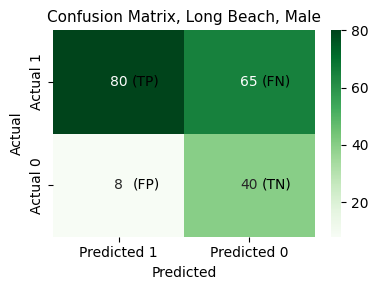

Naive Rate, Predict Negative: 0.24870466321243523
True Positive Rate: 0.5517241379310345
False Negative Rate: 0.4482758620689655
False Positive Rate: 0.16666666666666666
True Negative Rate: 0.8333333333333334
Precision: 0.9090909090909091
Negative Predictive Value: 0.38095238095238093
accuracy score 0.6217616580310881
f1 score 0.6866952789699571


In [199]:
# Confusion Matrix for VA LongBeach Data (male datapoints) for feature sets 1 and 2
cm = confusion_matrix(1-va_y_m, 1-va_y_pred_lr_s_m)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Predicted 1", "Predicted 0"],
            yticklabels=["Actual 1", "Actual 0"])
labels = [["TP", "FN"], ["FP", "TN"]]
for i in range(2):
    for j in range(2):
        plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                 ha="center", va="center", fontsize="medium")
plt.title('Confusion Matrix, Long Beach, Male', fontsize=11)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(f'Naive Rate, Predict Negative:', cm[1].sum()/cm.sum())
print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
print(f'Precision:', cm[0,0]/cm[:,0].sum())
print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())

va_y_pred_lr_m_1 = (lr_1.predict(add_const(va_X_m_1)) >= threshold).astype(int)
va_y_pred_lr_m_2 = (lr_2.predict(add_const(va_X_m_2)) >= threshold).astype(int)
va_y_pred_lr_m = np.concatenate((va_y_pred_lr_m_1, va_y_pred_lr_m_2), axis=0)
va_y_m = np.concatenate((va_y_m_1, va_y_m_2), axis=0)
#print(accuracy_score(va_y_m, va_y_pred_lr_m))
print("accuracy score", accuracy_score(va_y_m, va_y_pred_lr_s_m))
print("f1 score", f1_score(va_y_m, va_y_pred_lr_s_m))

### Logistic Regression Feature Perturbation

In [200]:
# Feature Modification
# Define different feature combinations to explore
feature_combinations = [
    ['age', 'cp'],
    ['sex', 'cp'],
    ['age', 'cp', 'thalach', 'exang'],
    ['sex', 'cp', 'thalach', 'exang'],
    ['age', 'sex', 'cp', 'trestbps'],
    ['age', 'sex', 'cp', 'chol'],
    ['age', 'sex', 'cp', 'fbs'],
    ['age', 'sex', 'cp', 'restecg'],
    ['age', 'sex', 'cp', 'thalach'],
    ['age', 'sex', 'cp', 'exang'],
    ['age', 'sex', 'cp', 'oldpeak'],
    ['age', 'sex', 'cp', 'slope'],
    ['age', 'sex', 'cp', 'ca'],
    ['age', 'sex', 'cp', 'thal']
]

In [201]:
# Define the datasets to analyze
datasets = [
    ('switz', switz_data),
    ('hung', hung_data),
    ('va', va_data)
]


In [202]:
# Train logistic regression models for each feature combination and dataset
trained_models = {}

for features in feature_combinations:
    X_train = clev_data[features]
    y_train = clev_data['target']
    not_missing = X_train.notna().all(axis=1)
    X_train = X_train[not_missing]
    y_train = y_train[not_missing]
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    model_name = f"lr_clev_{'_'.join(features)}"
    trained_models[model_name] = lr_model

In [203]:
trained_models_accuracy_cm = {}
trained_models_accuracy_cm_male = {}
trained_models_accuracy_cm_female = {}

for dataset_name, dataset in datasets:
    for features in feature_combinations:
        dataset_filtered = dataset[features + ['target']].dropna()
        X_test = dataset_filtered[features]
        y_test = dataset_filtered['target']

        model_name = f"lr_clev_{'_'.join(features)}"
        model = trained_models[model_name]

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(1 - y_test, 1 - y_pred)

        trained_models_accuracy_cm[(dataset_name, model_name)] = [features, accuracy, cm]

        dataset_male = dataset[dataset['sex'] == 1]
        dataset_female = dataset[dataset['sex'] == 0]

        dataset_filtered_male = dataset_male[features + ['target']].dropna()
        dataset_filtered_female = dataset_female[features + ['target']].dropna()

        if len(dataset_filtered_male) > 0:
            X_test_male = dataset_filtered_male[features]
            y_test_male = dataset_filtered_male['target']

            y_pred_male = model.predict(X_test_male)
            accuracy_male = accuracy_score(y_test_male, y_pred_male)
            cm_male = confusion_matrix(1 - y_test_male, 1 - y_pred_male)

            trained_models_accuracy_cm_male[(dataset_name, model_name)] = [features, accuracy_male, cm_male]

        if len(dataset_filtered_female) > 0:
            X_test_female = dataset_filtered_female[features]
            y_test_female = dataset_filtered_female['target']

            y_pred_female = model.predict(X_test_female)
            accuracy_female = accuracy_score(y_test_female, y_pred_female)
            cm_female = confusion_matrix(1 - y_test_female, 1 - y_pred_female)

            trained_models_accuracy_cm_female[(dataset_name, model_name)] = [features, accuracy_female, cm_female]

In [204]:
def generate_output(model_name, dataset_name, features, accuracy, cm):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=["Predicted 1", "Predicted 0"],
                yticklabels=["Actual 1", "Actual 0"])
    labels = [["TP", "FN"], ["FP", "TN"]]
    for i in range(2):
        for j in range(2):
            plt.text(j+0.71, i+0.42, f"\n({labels[i][j]})",
                    ha="center", va="center", fontsize="medium")
    plt.title(f'Confusion Matrix, {dataset_name}, {model_name}', fontsize=11)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    print(f'Dataset: {dataset_name}, Features: {features}')
    print(f'Model Accuracy:', accuracy)
    print(f'Naive Rate, Predict Majority Class:', max(cm[0].sum(),cm[1].sum())/cm.sum())
    print(f'True Positive Rate:', cm[0,0]/cm[0].sum())
    print(f'False Negative Rate:', cm[0,1]/cm[0].sum())
    print(f'False Positive Rate:', cm[1,0]/cm[1].sum())
    print(f'True Negative Rate:', cm[1,1]/cm[1].sum())
    print(f'Precision:', cm[0,0]/cm[:,0].sum())
    print(f'Negative Predictive Value:', cm[1,1]/cm[:,1].sum())

For visualization purposes, we won't display evaluation metrics for this section, as there are too many models and the goal of doing the feature perturbation is to better understand how different features are being used in our model.

We observe variations in accuracy, precision, recall, and other metrics. For example, in the Switzerland dataset, the feature combination ['sex', 'cp', 'thalach', 'exang'] achieves the highest overall accuracy of 0.8430, while ['age', 'sex', 'cp', 'chol'] has the lowest accuracy of 0.5.

However, accuracy alone does not provide a complete picture of the model's fairness. When examining the performance for male and female subgroups separately, we notice significant disparities. In the Hungary dataset, the feature combination ['age', 'cp'] has a higher accuracy for females (0.7778) compared to males (0.7547), but the true positive rate is much lower for females (0.3333) than males (0.6809), indicating a bias against female patients.

We conclude that adding features such as 'thalach' (maximum heart rate) and 'exang' (exercise-induced angina) generally improved model performance. The combination ['sex', 'cp', 'thalach', 'exang'] achieved the highest accuracy in the Switzerland dataset (0.8430). We also noted that it is important to include sensitive features - the model are being less fair between male and female groups when we removed 'gender' feature in the model training.

# 6. Results

### a. Interpret the results

    i. Do your model estimates seem reasonable? Why or why not? (e.g., provide examples of some model predictions like “for a 30 year old female patient, our model predicts x% risk, whereas for a 30 year old male patient, our model predicts y% risk”)
    
    ii. What can you say about your model performance (e.g., based on the evaluation metrics you calculated)?

## Logistic Regression:
#### Original Switzerland
|Model Preformance|overall|female|male|
|---|---|---|---|
|Accuracy|0.84|0.40|0.88|
|Precision|0.96|1.0|0.96|
|True Positive Rate|0.87|0.40|0.91|
|False Negative Rate|0.13|0.60|0.09|
|False Positive Rate|0.50|NaN|0.50|
|True Negative Rate|0.50|NaN|0.50|
|F1 Score|0.91|0.57|0.93|

#### Stratified Switerland
|Model Preformance|overall|female|male|
|---|---|---|---|
|Accuracy|0.43|0.30|0.44|
|Precision|0.98|1.0|0.98|
|True Positive Rate|0.39|0.30|0.40|
|False Negative Rate|0.60|0.70|0.60|
|False Positive Rate|0.12|nan|0.12|
|True Negative Rate|0.87|nan|0.87|
|F1 score|0.56|0.46|0.57|

#### Original Hungarian
|Model Preformance|overall|female|male|
|---|---|---|---|
|Accuracy|0.77|0.83|0.74|
|Precision|0.65|0.40|0.67|
|True Positive Rate|0.79|0.33|0.85|
|False Negative Rate|0.21|0.67|0.15|
|False Positive Rate|0.24|0.08|0.34|
|True Negative Rate|0.75|0.91|0.66|
|F1 Score|0.71|0.36|0.75|

#### Stratified Hangarian
|Model Preformance|overall|female|male|
|---|---|---|---|
|Accuracy|0.78|0.84|0.76|
|Precision|0.83|0.44|0.67|
|True Positive Rate|0.5|0.33|0.85|
|False Negative Rate|0.5|0.67|0.15|
|False Positive Rate|0.06|0.07|0.34|
|True Negative Rate|0.94|0.93|0.66|
|F1 Score|0.62|0.38|0.66|

#### Original Long Beach
|Model Preformance|overall|female|male|
|---|---|---|---|
|Accuracy|0.76|0.67|0.76|
|Precision|0.80|0.67|0.80|
|True Positive Rate|0.90|0.67|0.90|
|False Negative Rate|0.10|0.33|0.09|
|False Positive Rate|0.65|0.33|0.67|
|True Negative Rate|0.35|0.67|0.33|
|F1 Score|0.85|0.67|0.85|

#### Stratified Long Beach
|Model Preformance|overall|female|male|
|---|---|---|---|
|Accuracy|0.63|0.83|0.62|
|Precision|0.91|1.0|0.91|
|True Positive Rate|0.55|0.67|0.55|
|False Negative Rate|0.44|0.33|0.45|
|False Positive Rate|0.16|0.0|0.17|
|True Negative Rate|0.84|1.0|0.83|
|F1 Score|0.69|0.8|0.69|


## As precision is our main point of interest, we compare precision across datasets in stratified sampling

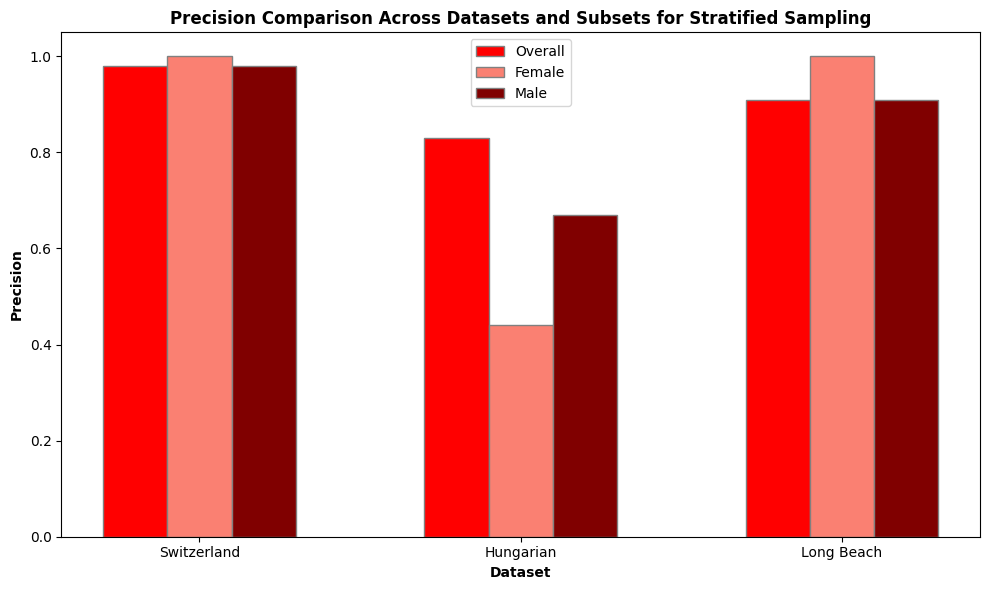

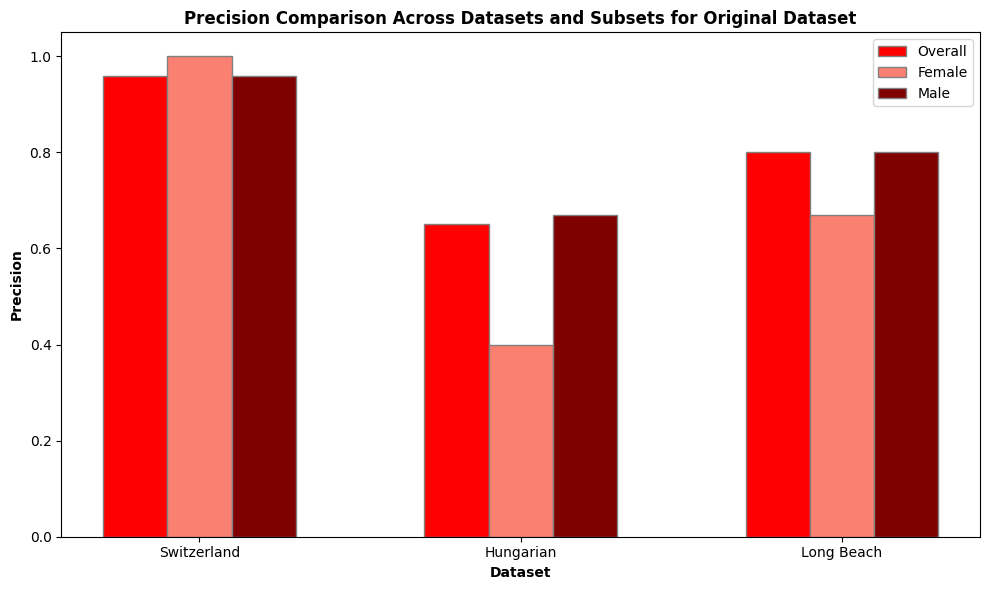

In [206]:
datasets = ['Switzerland', 'Hungarian', 'Long Beach']
metrics = ['Precision']

performance1 = {
    'Switzerland': {'Precision': [0.98,	1.0,	0.98]},
    'Hungarian': {'Precision': [0.83,	0.44,	0.67]},
    'Long Beach': {'Precision': [0.91,	1.0,	0.91]}
}

performance2 = {
    'Switzerland': {'Precision': [0.96,	1.0,	0.96]},
    'Hungarian': {'Precision': [0.65,	0.40,	0.67]},
    'Long Beach': {'Precision': [0.80,	0.67,	0.80]}
}


bar_width = 0.2

r1 = np.arange(len(datasets))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

for metric in metrics:
    plt.figure(figsize=(10, 6))


    plt.bar(r1, [performance1[dataset][metric][0] for dataset in datasets], color='red', width=bar_width, edgecolor='grey', label='Overall')
    plt.bar(r2, [performance1[dataset][metric][1] for dataset in datasets], color='salmon', width=bar_width, edgecolor='grey', label='Female')
    plt.bar(r3, [performance1[dataset][metric][2] for dataset in datasets], color='maroon', width=bar_width, edgecolor='grey', label='Male')


    plt.xlabel('Dataset', fontweight='bold')
    plt.ylabel(metric, fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(datasets))], datasets)
    plt.title(f'{metric} Comparison Across Datasets and Subsets for Stratified Sampling', fontweight='bold')
    plt.legend()


    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))

    plt.bar(r1, [performance2[dataset][metric][0] for dataset in datasets], color='red', width=bar_width, edgecolor='grey', label='Overall')
    plt.bar(r2, [performance2[dataset][metric][1] for dataset in datasets], color='salmon', width=bar_width, edgecolor='grey', label='Female')
    plt.bar(r3, [performance2[dataset][metric][2] for dataset in datasets], color='maroon', width=bar_width, edgecolor='grey', label='Male')


    plt.xlabel('Dataset', fontweight='bold')
    plt.ylabel(metric, fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(datasets))], datasets)
    plt.title(f'{metric} Comparison Across Datasets and Subsets for Original Dataset', fontweight='bold')
    plt.legend()


    plt.tight_layout()
    plt.show()


### Note that we have increased precision in our stratified sampling.

### i. Do your model estimates seem reasonable?
**The model estimates seem reasonable:**

- For Hungarian and Long Beach patients, the model's accuracy remained similar, Hungarian increased from `76.8%` to `78.2%` and Long Beach dropped from `75.9%` to `62.8%` after the stratification. We did observe a significant change in false negative rate and false positive rate. The false positive rate increase a little bit while the false negative rate decreased significantly after stratification for both Hungarian and Long Beach patients.

- For a Switzerland patient, the model predicts a `84.4%` accuracy, with a `96.1%` precision and `86.8%` true positive rate for heart disease, but the model predicts a `42.6%` accuracy, with a `97.8%` precision and `39.5%` true positive rate for heart disease after stratification. The model performed worse after the stratification and the model didn't become more fair. The false negative rate increased significantly while the false positive rate reduced.

The changes in performance metrics, especially in Accuracy and Precision, suggest that the model's ability to predict accurately and precisely has been impacted by stratification. Such significant changes raise questions about the model's consistency and how well it generalizes across different subsets of the data.  

For instance, in the stratified data for Switzerland, the Precision remains extremely high (near 1.0) for males, yet the Accuracy significantly drops. This discrepancy could indicate that while the model is very precise in its positive predictions, it struggles with correctly identifying a substantial portion of the true conditions (either positive or negative), leading to lower overall accuracy.

We believe the unexpected outcome is due to the stratification on imbalanced data set leading to many missing data points.

### ii. What can you say about your model performance (e.g., based on the evaluation metrics you calculated)?

The model exhibits strong predictive capabilities overall, particularly with a high precision rate. However, its performance is markedly better for male patients than for female patients, as evidenced by significantly higher accuracy, TPR, and lower FNR for males.

The high FPR and low accuracy for females highlight a critical area for improvement. These discrepancies suggest that the model might be biased towards male patients, potentially due to imbalances in the training data or differences in disease presentation that are not adequately captured by the model's features.

However, comparing to the original models, excluding Switzerland patient due to the missing data, we observed a better performance for females with a slite worse performance on male prediction, indicating that the model after stratification is indeed more fair than the original model. We are happy with the model performance yet there are still areas to improve.

### b. How do your results support or reject your hypotheses from Section 1?

**For the Hypothesis**:

Our results does show that gender-based disparities in False Positive Rates (FPR) and False Negative Rates (FNR) can be mitigated using Stratified Sampling, with limitations. We see that FPR and FNR for females are slitely improved for Hungarian patients and they are improved a lot for Long Beach patients.

For example, there was a significant difference of FNR and FPR between male and female for the original Long Beach patients - `33.3%` (female) vs. `9.7%` (male) in FNR and `33.3%` (female) vs. `66.7%` (male) in FPR. This is improved to `33.3%` (female) vs. `44.8%` (male) in FNR and `0%` (female) vs. `16.7%` (male) in FPR, which is a lot closer between different genders.

The decrease in TPR and FPR, coupled with an increase in TNR and FNR, suggests that our model is becoming more conservative - better at identifying true negatives but also more likely to miss true positives. This could be a result of a newfound balance in training where previously underrepresented data is now pulling the model's focus, possibly affecting its overall sensitivity and specificity balance. In medical diagnostics, a conservative model might be preferable if the cost of a false positive (e.g., unnecessary treatment based on a wrong diagnosis) is very high.

Therefore, we can conclude that our Hypothesis is supported by the results.



Furthermore, we look at the Precision. To validate our hypothesis, we need the Precision with the Stratified Algorithm to be higher than the Precision with the Original Algorithm. This is because in a healthcare scenario misdiagnosis can be highly dangerous because it is a very high-stakes scenario of heart disease. This kind of issue can lead to delay in interventions and treatment and can lead to poorer health outcomes and even death. For Switzerland the original algorithm has an overall Precision of `0.96` and our algorithm has Precision of `0.97`. For Hungarian the original algorithm has an overall Precision of `0.64`and our algorithm has Precision of `0.82`. For Long Beach VA the original algorithm has an overall Precision of `0.80` and our algorithm has Precision of `0.91`. An interesting thing to note here for all the three cases is that even though we set out to make the predictions more equitable for females, it also increased the precision for males in our algorithms. It is this combined increase of precision for both females and males contributes to the overall increase in precision as compared to the original algorithm.


# 7. Conclusion & Limitations

## Conclusion
In conclusion, our analysis supports the effectiveness of stratified sampling in addressing gender disparities and enhancing overall precision in medical diagnostic models:

1. **Reducing Gender Disparities**: Stratified sampling significantly mitigated disparities in False Positive Rates (FPR) and False Negative Rates (FNR) between genders, particularly noticeable in the Long Beach patient data. This adjustment led to more conservative model behavior, which, while reducing the rate of false positives significantly, tended to miss more true positives, reflecting a trade-off in model sensitivity and specificity.

2. **Improving Diagnostic Precision**: The implementation of stratified sampling not only enhanced fairness across gender lines but also improved the overall precision of predictions. This increase in precision was observed across all patient groups analyzed—Switzerland, Hungarian, and Long Beach VA—benefitting both male and female patients. This improvement is crucial in high-stakes environments like healthcare, where the accuracy of diagnostics can significantly impact patient outcomes.

3. **Decreased Overall Accuracy**: While we successfully narrowed the performance gap between male and female patients, the overall accuracy of the model decreased. This reduction in accuracy was primarily due to the limited number of data points for female patients, which poses a challenge to our model's learning capability and generalizability.

Overall, the use of stratified sampling has proven to be a valuable strategy in refining the performance of diagnostic models, ensuring both greater equity and higher accuracy in medical diagnostics. However, the model's reliability might be less confident due to the lower accuracy after stratification, suggesting us should explore advanced machine learning techniques designed for imbalanced data, such as synthetic data generation or different algorithmic adjustments, which could also be beneficial.

## Limitations:
**Data**:
The analysis presented in our study confronts significant data limitations that influence the performance outcomes of the models evaluated, particularly XGBoost. A primary concern is the handling of missing data. XGBoost, known for its sensitivity to incomplete datasets, encounters challenges in the stratified data where NaN values are prevalent. This shortage of complete data points could be preventing the model from effectively learning and making accurate predictions, particularly in segments of the dataset that are under-represented or contain insufficient feature information. Such data sparsity is likely contributing to the observed suboptimal performance metrics.

Furthermore, the stratification process itself introduces another critical issue—particularly the sharp decline in the number of positive examples for female data. This reduction exacerbates the challenge of model training where the limited instances for females do not provide enough learning opportunities, thus affecting both precision and recall adversely. The sensitivity of XGBoost to imbalanced data is particularly problematic in this context, as the decreased frequency of female examples after stratification results in poor model performance. This imbalance not only skews the model’s ability to generalize across different subgroups but also impacts the overall fairness and efficacy of the predictive outcomes.

Additionally, our study employs datasets from multiple geographical locations for training and testing the models, which raises the issue of distribution shift. Although all four datasets are funded by The National Institutes of Health and published in the same repository, the distribution shift still may exist. This variability could introduce biases if the populations represented in these datasets differ in sociodemographic factors that correlate with heart disease risk or interact with the predictive features in a manner that alters the risk profile. For example, using datasets from different countries may incorporate varying lifestyle, healthcare access, and genetic predispositions that are not uniformly distributed across the datasets. This shift could potentially invalidate the assumption that these datasets are representative of the same underlying population, thereby affecting the generalizability and accuracy of the predictive models. Addressing this concern requires careful examination of the datasets' collection methodologies and possibly integrating external data to adjust for these sociological and demographic factors.

These data limitations highlight the necessity for robust data preprocessing and possibly reconsidering the stratification strategy to ensure a more balanced and representative dataset.

**Modeling**:

- Logistic Regression demonstrates a good balance between precision and TPR in many cases, with generally consistent performance across genders and stratified conditions. However, its accuracy and TPR may lag behind Random Forest in some datasets, indicating potential limitations in capturing complex non-linear relationships.

- Random Forest generally shows robust performance across different datasets, maintaining a balance between precision, TPR, and accuracy. It tends to be more stable across stratified data, indicating good generalization capabilities and resistance to overfitting.

- XGBoost exhibits high precision in many scenarios but struggles with sensitivity (TPR), especially in stratified datasets and for specific gender groups. This suggests a potential overfitting to the majority class or difficulty in handling imbalanced data, which will be investigated further.

**Analysis**:
In our analysis, we analyzed the performance of different models using original and augmented data sets, including the replication of models and stratified sampling, presents several potential limitations that could impact the validity and reliability of the findings:

- Overfitting Risk: Although Random Forest is generally robust against overfitting, its performance heavily depends on the diversity of the bootstrapped trees. If the trees are too similar, the model might still overfit.
- Sensitivity to Imbalanced Data: XGBoost can perform poorly if the data is imbalanced, despite measures such as stratified sampling. It might overly focus on the majority class, leading to suboptimal performance in minority classes.
- Synthetic Data Limitations: While stratified sampling can help create a more representative data set, it may also introduce biases if the resampling is not perfectly aligned with the underlying population distributions. This can affect the generalizability of the models.


To address above issues, we can consider the following steps to improve the model's performance:

- **Handling Missing Data**: Since XGBoost is sensitive to missing data, we can explore strategies to handle NaN values, such as replacing NaN values with median or average values, to ensure that the model has sufficient information to make accurate predictions.
- **Handling Data Imbalance**: We can explore techniques to address class imbalance, such as giving more weight to minority classes(female data) to proriortize the minority class.

With these steps, we can improve the model's performance and ensure that it can make accurate predictions for all groups, and design a model that is fair and unbiased.

## Validation/Reliability of our assumptions
Our approach effectively reduced gender disparities, aligning with fairness objectives. However, the trade-off was a decrease in overall accuracy. The limited number of female data points highlights a common challenge in data-driven models—data imbalance. When the minority class has significantly fewer samples, the model's ability to learn from and generalize to that class can be compromised, impacting overall model performance.

To address this, further statistical analysis is needed to assess the significance of the observed improvements in fairness against the backdrop of decreased accuracy. Techniques such as cross-validation and external validations could be employed to verify the robustness and consistency of the model across different datasets.

In conclusion, while our model has made process in reducing gender disparities, the trade-offs indicate the complexities involved in modeling real-world scenarios. The insights gained from this exercise will guide our future strategies in model development, particularly in emphasizing the need for balanced data and the continual reevaluation of model assumptions and performance.

# 8. Contribution Notes

Srimoyee - Modeling, accuracy and fairness metrics and evaluation(Section 3 upto and not including Feature Perturbation), validation for Hypothesis (Section 6), additional graphs (Section 6 - results plotting, Section 4 - readability plots)

Hongjin - Section 1, 6, 7(Introduction, Results, Conclusions & Limitations)

Lancaster - Modeling (Section 5), Results, Validation for Hypothesis (Section 6), Formated Section 3 Markdown, Limitations (Section 7)

Arman - Phase 2 Data Import and Cleaning (Section 1), Summary Statistics (Section 2), Research question, hypothesis, analysis plan (Section 3)
Phase 5 Sections 2, 3, & 4

# 9. Sources

[1] Robert Detrano, Andras Janosi, Walter Steinbrunn, et al. 1989. International Application of a New Probability Algorithm for the Diagnosis of Coronary Artery Disease. The American Journal of Cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9

[2] Andras Janosi, William Steinbrunn, Matthias Pfisterer, and Robert Detrano. 1988. Heart Disease. Retrieved February 16, 2024. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X

[3] Lloyd-Jones, D.M., Larson, M.G., Leip, E.P., Beiser, A., D’Agostino, R.B., Kannel, W.B., Murabito, J.M., Vasan, R.S., Benjamin, E.J., Levy, D. 2002. Lifetime Risk for Developing Congestive Heart Failure: The Framingham Heart Study. Circulation, 106(23): 3068-3072. https://doi.org/10.1161/01.cir.0000039105.49749.6f

[3] Damon Centola, Douglas Guilbeault, Urmimala Sarkar, Elaine Khoong, Jingwen Zhang, et al. 2021 The reduction of race and gender bias in clinical treatment recommendations using clinician peer networks in an experimental setting. Nat Commun 12, 6585. https://doi.org/10.1038/s41467-021-26905-5

[4] Fuchen Li, Patrick Wu, Henry H. Ong, Josh F. Peterson, Wei-Qi Wei, Juan Zhao. 2023. Evaluating and mitigating bias in machine learning models for cardiovascular disease prediction. J Biomed Inform. Feb 2023; 138: 104294. DOI: 10.1016/j.jbi.2023.104294. Epub 2023 Jan 24. PMID: 36706849.

[5] G.A. Panza, R.M, Puhl, B.A Taylor, A.L Zaleski, J Livingston, L.S Pescatello. 2019. Links between discrimination and cardiovascular health among socially stigmatized groups: A systematic review. PloS one, 14, 6 (2019), e0217623.

[6] O.H Meléndez-Fernández, J.C Walton, A.C DeVries, R.J. Nelson, 2021 Clocks, rhythms, sex, and hearts: How disrupted circadian rhythms, time-of-day, and sex influence cardiovascular health. Biomolecules, 11, 6 (2021), 883.
